In [1]:
!pip install -r ../../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'CustomBaselineV2'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dataaugmentationlib

import math

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [9]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

X_train, Y_train = dataaugmentationlib.horizontal_and_vertical_flip_and_concatenate_with_signals(X_train, Y_train)

## Build the Neural Network

In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(495000, 2, 128)
[2, 128]


In [11]:
model = neural_networks.custom_baseline_v2(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IQ (InputLayer)              [(None, 2, 128)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2, 36)             9252      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2, 18)             2610      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 18)             0         
_________________________________________________________________
flatten (Flatten)            (None, 18)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               4864      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896 

### Train the model

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


  1/436 [..............................] - ETA: 1:23:22 - loss: 2.3978

 11/436 [..............................] - ETA: 2s - loss: 2.3977     

 22/436 [>.............................] - ETA: 2s - loss: 2.3974

 33/436 [=>............................] - ETA: 2s - loss: 2.3964

 44/436 [==>...........................] - ETA: 1s - loss: 2.3944

 55/436 [==>...........................] - ETA: 1s - loss: 2.3901

 67/436 [===>..........................] - ETA: 1s - loss: 2.3823

 78/436 [====>.........................] - ETA: 1s - loss: 2.3738



 89/436 [=====>........................] - ETA: 1s - loss: 2.3650

100/436 [=====>........................] - ETA: 1s - loss: 2.3564

111/436 [======>.......................] - ETA: 1s - loss: 2.3481

122/436 [=======>......................] - ETA: 1s - loss: 2.3402

133/436 [========>.....................] - ETA: 1s - loss: 2.3327

145/436 [========>.....................] - ETA: 1s - loss: 2.3251

156/436 [=========>....................] - ETA: 1s - loss: 2.3185

168/436 [==========>...................] - ETA: 1s - loss: 2.3117

179/436 [===========>..................] - ETA: 1s - loss: 2.3057

190/436 [============>.................] - ETA: 1s - loss: 2.2999

202/436 [============>.................] - ETA: 1s - loss: 2.2937

213/436 [=============>................] - ETA: 1s - loss: 2.2882

225/436 [==============>...............] - ETA: 0s - loss: 2.2822

237/436 [===============>..............] - ETA: 0s - loss: 2.2764

248/436 [================>.............] - ETA: 0s - loss: 2.2711



260/436 [================>.............] - ETA: 0s - loss: 2.2655

271/436 [=================>............] - ETA: 0s - loss: 2.2604



283/436 [==================>...........] - ETA: 0s - loss: 2.2550

295/436 [===================>..........] - ETA: 0s - loss: 2.2496

306/436 [====================>.........] - ETA: 0s - loss: 2.2449

317/436 [====================>.........] - ETA: 0s - loss: 2.2402

328/436 [=====================>........] - ETA: 0s - loss: 2.2357

339/436 [======================>.......] - ETA: 0s - loss: 2.2313

350/436 [=======================>......] - ETA: 0s - loss: 2.2269



362/436 [=======================>......] - ETA: 0s - loss: 2.2223

373/436 [========================>.....] - ETA: 0s - loss: 2.2182

385/436 [=========================>....] - ETA: 0s - loss: 2.2138

396/436 [==========================>...] - ETA: 0s - loss: 2.2099

407/436 [===========================>..] - ETA: 0s - loss: 2.2060

418/436 [===========================>..] - ETA: 0s - loss: 2.2023



430/436 [============================>.] - ETA: 0s - loss: 2.1983

436/436 [==============================] - ETA: 0s - loss: 2.1964

436/436 [==============================] - 14s 6ms/step - loss: 2.1961 - val_loss: 1.9171


Epoch 2/100
  1/436 [..............................] - ETA: 2s - loss: 1.8860

 12/436 [..............................] - ETA: 2s - loss: 1.9018

 23/436 [>.............................] - ETA: 1s - loss: 1.8995

 34/436 [=>............................] - ETA: 1s - loss: 1.8985

 46/436 [==>...........................] - ETA: 1s - loss: 1.8972

 57/436 [==>...........................] - ETA: 1s - loss: 1.8963

 68/436 [===>..........................] - ETA: 1s - loss: 1.8954

 80/436 [====>.........................] - ETA: 1s - loss: 1.8946

 93/436 [=====>........................] - ETA: 1s - loss: 1.8940

106/436 [======>.......................] - ETA: 1s - loss: 1.8935

118/436 [=======>......................] - ETA: 1s - loss: 1.8930

131/436 [========>.....................] - ETA: 1s - loss: 1.8925



144/436 [========>.....................] - ETA: 1s - loss: 1.8920

157/436 [=========>....................] - ETA: 1s - loss: 1.8914



171/436 [==========>...................] - ETA: 1s - loss: 1.8908

184/436 [===========>..................] - ETA: 1s - loss: 1.8902

197/436 [============>.................] - ETA: 1s - loss: 1.8897

210/436 [=============>................] - ETA: 0s - loss: 1.8891



221/436 [==============>...............] - ETA: 0s - loss: 1.8886

233/436 [===============>..............] - ETA: 0s - loss: 1.8880



246/436 [===============>..............] - ETA: 0s - loss: 1.8875

259/436 [================>.............] - ETA: 0s - loss: 1.8869

271/436 [=================>............] - ETA: 0s - loss: 1.8864



283/436 [==================>...........] - ETA: 0s - loss: 1.8858

295/436 [===================>..........] - ETA: 0s - loss: 1.8852

307/436 [====================>.........] - ETA: 0s - loss: 1.8846

318/436 [====================>.........] - ETA: 0s - loss: 1.8841

330/436 [=====================>........] - ETA: 0s - loss: 1.8835



342/436 [======================>.......] - ETA: 0s - loss: 1.8829

354/436 [=======================>......] - ETA: 0s - loss: 1.8823

365/436 [========================>.....] - ETA: 0s - loss: 1.8818



377/436 [========================>.....] - ETA: 0s - loss: 1.8812

389/436 [=========================>....] - ETA: 0s - loss: 1.8806

401/436 [==========================>...] - ETA: 0s - loss: 1.8801

413/436 [===========================>..] - ETA: 0s - loss: 1.8795

425/436 [============================>.] - ETA: 0s - loss: 1.8790

436/436 [==============================] - 2s 5ms/step - loss: 1.8784 - val_loss: 1.8352


Epoch 3/100
  1/436 [..............................] - ETA: 2s - loss: 1.8600

 12/436 [..............................] - ETA: 1s - loss: 1.8212

 24/436 [>.............................] - ETA: 1s - loss: 1.8173

 37/436 [=>............................] - ETA: 1s - loss: 1.8147

 50/436 [==>...........................] - ETA: 1s - loss: 1.8124



 62/436 [===>..........................] - ETA: 1s - loss: 1.8111

 74/436 [====>.........................] - ETA: 1s - loss: 1.8097

 88/436 [=====>........................] - ETA: 1s - loss: 1.8083



102/436 [======>.......................] - ETA: 1s - loss: 1.8072

116/436 [======>.......................] - ETA: 1s - loss: 1.8062

130/436 [=======>......................] - ETA: 1s - loss: 1.8054

144/436 [========>.....................] - ETA: 1s - loss: 1.8046

158/436 [=========>....................] - ETA: 1s - loss: 1.8038

172/436 [==========>...................] - ETA: 1s - loss: 1.8031

186/436 [===========>..................] - ETA: 0s - loss: 1.8023

200/436 [============>.................] - ETA: 0s - loss: 1.8015

214/436 [=============>................] - ETA: 0s - loss: 1.8008

227/436 [==============>...............] - ETA: 0s - loss: 1.8000

240/436 [===============>..............] - ETA: 0s - loss: 1.7993

254/436 [================>.............] - ETA: 0s - loss: 1.7985

267/436 [=================>............] - ETA: 0s - loss: 1.7978

280/436 [==================>...........] - ETA: 0s - loss: 1.7971

293/436 [===================>..........] - ETA: 0s - loss: 1.7965

306/436 [====================>.........] - ETA: 0s - loss: 1.7959

319/436 [====================>.........] - ETA: 0s - loss: 1.7952



332/436 [=====================>........] - ETA: 0s - loss: 1.7946

345/436 [======================>.......] - ETA: 0s - loss: 1.7940

358/436 [=======================>......] - ETA: 0s - loss: 1.7934

372/436 [========================>.....] - ETA: 0s - loss: 1.7928

386/436 [=========================>....] - ETA: 0s - loss: 1.7921

399/436 [==========================>...] - ETA: 0s - loss: 1.7916

412/436 [===========================>..] - ETA: 0s - loss: 1.7910

426/436 [============================>.] - ETA: 0s - loss: 1.7904

436/436 [==============================] - 2s 4ms/step - loss: 1.7899 - val_loss: 1.8064


Epoch 4/100
  1/436 [..............................] - ETA: 2s - loss: 1.7895

 15/436 [>.............................] - ETA: 1s - loss: 1.7655

 28/436 [>.............................] - ETA: 1s - loss: 1.7602

 41/436 [=>............................] - ETA: 1s - loss: 1.7565

 53/436 [==>...........................] - ETA: 1s - loss: 1.7531

 66/436 [===>..........................] - ETA: 1s - loss: 1.7502

 79/436 [====>.........................] - ETA: 1s - loss: 1.7481

 93/436 [=====>........................] - ETA: 1s - loss: 1.7464

107/436 [======>.......................] - ETA: 1s - loss: 1.7453



121/436 [=======>......................] - ETA: 1s - loss: 1.7445



135/436 [========>.....................] - ETA: 1s - loss: 1.7436

149/436 [=========>....................] - ETA: 1s - loss: 1.7428



163/436 [==========>...................] - ETA: 1s - loss: 1.7420

176/436 [===========>..................] - ETA: 1s - loss: 1.7413



189/436 [============>.................] - ETA: 0s - loss: 1.7406



202/436 [============>.................] - ETA: 0s - loss: 1.7399

216/436 [=============>................] - ETA: 0s - loss: 1.7392

230/436 [==============>...............] - ETA: 0s - loss: 1.7386



243/436 [===============>..............] - ETA: 0s - loss: 1.7380

256/436 [================>.............] - ETA: 0s - loss: 1.7374

269/436 [=================>............] - ETA: 0s - loss: 1.7368



281/436 [==================>...........] - ETA: 0s - loss: 1.7363

294/436 [===================>..........] - ETA: 0s - loss: 1.7357

307/436 [====================>.........] - ETA: 0s - loss: 1.7352

320/436 [=====================>........] - ETA: 0s - loss: 1.7346

333/436 [=====================>........] - ETA: 0s - loss: 1.7341

346/436 [======================>.......] - ETA: 0s - loss: 1.7336

360/436 [=======================>......] - ETA: 0s - loss: 1.7330

373/436 [========================>.....] - ETA: 0s - loss: 1.7325

387/436 [=========================>....] - ETA: 0s - loss: 1.7320

400/436 [==========================>...] - ETA: 0s - loss: 1.7315

413/436 [===========================>..] - ETA: 0s - loss: 1.7310

426/436 [============================>.] - ETA: 0s - loss: 1.7305

436/436 [==============================] - 2s 4ms/step - loss: 1.7301 - val_loss: 1.6960


Epoch 5/100
  1/436 [..............................] - ETA: 2s - loss: 1.6622

 13/436 [..............................] - ETA: 1s - loss: 1.6790

 26/436 [>.............................] - ETA: 1s - loss: 1.6790

 38/436 [=>............................] - ETA: 1s - loss: 1.6802

 50/436 [==>...........................] - ETA: 1s - loss: 1.6804

 63/436 [===>..........................] - ETA: 1s - loss: 1.6803

 77/436 [====>.........................] - ETA: 1s - loss: 1.6799

 90/436 [=====>........................] - ETA: 1s - loss: 1.6797

103/436 [======>.......................] - ETA: 1s - loss: 1.6795

116/436 [======>.......................] - ETA: 1s - loss: 1.6793

129/436 [=======>......................] - ETA: 1s - loss: 1.6790

142/436 [========>.....................] - ETA: 1s - loss: 1.6787

155/436 [=========>....................] - ETA: 1s - loss: 1.6784

168/436 [==========>...................] - ETA: 1s - loss: 1.6782



181/436 [===========>..................] - ETA: 1s - loss: 1.6780

193/436 [============>.................] - ETA: 1s - loss: 1.6777

206/436 [=============>................] - ETA: 0s - loss: 1.6775

219/436 [==============>...............] - ETA: 0s - loss: 1.6771

231/436 [==============>...............] - ETA: 0s - loss: 1.6769

244/436 [===============>..............] - ETA: 0s - loss: 1.6766

256/436 [================>.............] - ETA: 0s - loss: 1.6763

269/436 [=================>............] - ETA: 0s - loss: 1.6760

281/436 [==================>...........] - ETA: 0s - loss: 1.6757

294/436 [===================>..........] - ETA: 0s - loss: 1.6754

307/436 [====================>.........] - ETA: 0s - loss: 1.6751

320/436 [=====================>........] - ETA: 0s - loss: 1.6748

333/436 [=====================>........] - ETA: 0s - loss: 1.6745

346/436 [======================>.......] - ETA: 0s - loss: 1.6742

358/436 [=======================>......] - ETA: 0s - loss: 1.6739

371/436 [========================>.....] - ETA: 0s - loss: 1.6737

385/436 [=========================>....] - ETA: 0s - loss: 1.6734

398/436 [==========================>...] - ETA: 0s - loss: 1.6731

410/436 [===========================>..] - ETA: 0s - loss: 1.6728

423/436 [============================>.] - ETA: 0s - loss: 1.6725

436/436 [==============================] - ETA: 0s - loss: 1.6722

436/436 [==============================] - 2s 4ms/step - loss: 1.6722 - val_loss: 1.6598


Epoch 6/100
  1/436 [..............................] - ETA: 2s - loss: 1.6273

 13/436 [..............................] - ETA: 1s - loss: 1.6418

 25/436 [>.............................] - ETA: 1s - loss: 1.6444

 37/436 [=>............................] - ETA: 1s - loss: 1.6433

 48/436 [==>...........................] - ETA: 1s - loss: 1.6421

 60/436 [===>..........................] - ETA: 1s - loss: 1.6416

 73/436 [====>.........................] - ETA: 1s - loss: 1.6413

 86/436 [====>.........................] - ETA: 1s - loss: 1.6409

 99/436 [=====>........................] - ETA: 1s - loss: 1.6403

112/436 [======>.......................] - ETA: 1s - loss: 1.6396

124/436 [=======>......................] - ETA: 1s - loss: 1.6390

137/436 [========>.....................] - ETA: 1s - loss: 1.6384

149/436 [=========>....................] - ETA: 1s - loss: 1.6378

162/436 [==========>...................] - ETA: 1s - loss: 1.6373

175/436 [===========>..................] - ETA: 1s - loss: 1.6367

187/436 [===========>..................] - ETA: 1s - loss: 1.6363

200/436 [============>.................] - ETA: 0s - loss: 1.6358

213/436 [=============>................] - ETA: 0s - loss: 1.6354

225/436 [==============>...............] - ETA: 0s - loss: 1.6351

238/436 [===============>..............] - ETA: 0s - loss: 1.6347

250/436 [================>.............] - ETA: 0s - loss: 1.6344

262/436 [=================>............] - ETA: 0s - loss: 1.6340

275/436 [=================>............] - ETA: 0s - loss: 1.6337

288/436 [==================>...........] - ETA: 0s - loss: 1.6333

301/436 [===================>..........] - ETA: 0s - loss: 1.6330

314/436 [====================>.........] - ETA: 0s - loss: 1.6326

327/436 [=====================>........] - ETA: 0s - loss: 1.6322

340/436 [======================>.......] - ETA: 0s - loss: 1.6319

353/436 [=======================>......] - ETA: 0s - loss: 1.6315

366/436 [========================>.....] - ETA: 0s - loss: 1.6311

379/436 [=========================>....] - ETA: 0s - loss: 1.6308

391/436 [=========================>....] - ETA: 0s - loss: 1.6305

404/436 [==========================>...] - ETA: 0s - loss: 1.6301



416/436 [===========================>..] - ETA: 0s - loss: 1.6298

429/436 [============================>.] - ETA: 0s - loss: 1.6294



436/436 [==============================] - 2s 4ms/step - loss: 1.6292 - val_loss: 1.6162


Epoch 7/100
  1/436 [..............................] - ETA: 2s - loss: 1.5962

 13/436 [..............................] - ETA: 1s - loss: 1.6004

 24/436 [>.............................] - ETA: 1s - loss: 1.5986

 36/436 [=>............................] - ETA: 1s - loss: 1.5982

 49/436 [==>...........................] - ETA: 1s - loss: 1.5978

 62/436 [===>..........................] - ETA: 1s - loss: 1.5980

 75/436 [====>.........................] - ETA: 1s - loss: 1.5979

 88/436 [=====>........................] - ETA: 1s - loss: 1.5978

101/436 [=====>........................] - ETA: 1s - loss: 1.5976

113/436 [======>.......................] - ETA: 1s - loss: 1.5973

126/436 [=======>......................] - ETA: 1s - loss: 1.5971

138/436 [========>.....................] - ETA: 1s - loss: 1.5969

151/436 [=========>....................] - ETA: 1s - loss: 1.5967

164/436 [==========>...................] - ETA: 1s - loss: 1.5965

177/436 [===========>..................] - ETA: 1s - loss: 1.5962

190/436 [============>.................] - ETA: 1s - loss: 1.5960

202/436 [============>.................] - ETA: 0s - loss: 1.5958

214/436 [=============>................] - ETA: 0s - loss: 1.5956

227/436 [==============>...............] - ETA: 0s - loss: 1.5953

240/436 [===============>..............] - ETA: 0s - loss: 1.5951

253/436 [================>.............] - ETA: 0s - loss: 1.5949

266/436 [=================>............] - ETA: 0s - loss: 1.5947

279/436 [==================>...........] - ETA: 0s - loss: 1.5945

292/436 [===================>..........] - ETA: 0s - loss: 1.5943

305/436 [===================>..........] - ETA: 0s - loss: 1.5941

318/436 [====================>.........] - ETA: 0s - loss: 1.5939

330/436 [=====================>........] - ETA: 0s - loss: 1.5938

343/436 [======================>.......] - ETA: 0s - loss: 1.5936

356/436 [=======================>......] - ETA: 0s - loss: 1.5934

369/436 [========================>.....] - ETA: 0s - loss: 1.5932

382/436 [=========================>....] - ETA: 0s - loss: 1.5931

395/436 [==========================>...] - ETA: 0s - loss: 1.5929

409/436 [===========================>..] - ETA: 0s - loss: 1.5927

422/436 [============================>.] - ETA: 0s - loss: 1.5925

435/436 [============================>.] - ETA: 0s - loss: 1.5923

436/436 [==============================] - 2s 4ms/step - loss: 1.5923 - val_loss: 1.5944


Epoch 8/100
  1/436 [..............................] - ETA: 2s - loss: 1.5970

 14/436 [..............................] - ETA: 1s - loss: 1.5830

 26/436 [>.............................] - ETA: 1s - loss: 1.5815

 38/436 [=>............................] - ETA: 1s - loss: 1.5794

 50/436 [==>...........................] - ETA: 1s - loss: 1.5778



 63/436 [===>..........................] - ETA: 1s - loss: 1.5765

 76/436 [====>.........................] - ETA: 1s - loss: 1.5755

 89/436 [=====>........................] - ETA: 1s - loss: 1.5746

102/436 [======>.......................] - ETA: 1s - loss: 1.5739

114/436 [======>.......................] - ETA: 1s - loss: 1.5734



126/436 [=======>......................] - ETA: 1s - loss: 1.5730

139/436 [========>.....................] - ETA: 1s - loss: 1.5727

151/436 [=========>....................] - ETA: 1s - loss: 1.5725

164/436 [==========>...................] - ETA: 1s - loss: 1.5722



176/436 [===========>..................] - ETA: 1s - loss: 1.5720

189/436 [============>.................] - ETA: 1s - loss: 1.5718

203/436 [============>.................] - ETA: 0s - loss: 1.5716

216/436 [=============>................] - ETA: 0s - loss: 1.5714

229/436 [==============>...............] - ETA: 0s - loss: 1.5712

242/436 [===============>..............] - ETA: 0s - loss: 1.5710

255/436 [================>.............] - ETA: 0s - loss: 1.5708

266/436 [=================>............] - ETA: 0s - loss: 1.5706

278/436 [==================>...........] - ETA: 0s - loss: 1.5704

291/436 [===================>..........] - ETA: 0s - loss: 1.5702

304/436 [===================>..........] - ETA: 0s - loss: 1.5700

316/436 [====================>.........] - ETA: 0s - loss: 1.5699

329/436 [=====================>........] - ETA: 0s - loss: 1.5697



342/436 [======================>.......] - ETA: 0s - loss: 1.5696

355/436 [=======================>......] - ETA: 0s - loss: 1.5694

368/436 [========================>.....] - ETA: 0s - loss: 1.5693

381/436 [=========================>....] - ETA: 0s - loss: 1.5692

393/436 [==========================>...] - ETA: 0s - loss: 1.5691

406/436 [==========================>...] - ETA: 0s - loss: 1.5689

419/436 [===========================>..] - ETA: 0s - loss: 1.5688

432/436 [============================>.] - ETA: 0s - loss: 1.5687

436/436 [==============================] - 2s 4ms/step - loss: 1.5687 - val_loss: 1.5699


Epoch 9/100
  1/436 [..............................] - ETA: 2s - loss: 1.5311

 14/436 [..............................] - ETA: 1s - loss: 1.5453

 27/436 [>.............................] - ETA: 1s - loss: 1.5485

 39/436 [=>............................] - ETA: 1s - loss: 1.5491



 50/436 [==>...........................] - ETA: 1s - loss: 1.5496



 62/436 [===>..........................] - ETA: 1s - loss: 1.5496

 74/436 [====>.........................] - ETA: 1s - loss: 1.5496

 87/436 [====>.........................] - ETA: 1s - loss: 1.5493

101/436 [=====>........................] - ETA: 1s - loss: 1.5491

114/436 [======>.......................] - ETA: 1s - loss: 1.5490

127/436 [=======>......................] - ETA: 1s - loss: 1.5489

140/436 [========>.....................] - ETA: 1s - loss: 1.5489

153/436 [=========>....................] - ETA: 1s - loss: 1.5491

166/436 [==========>...................] - ETA: 1s - loss: 1.5493

179/436 [===========>..................] - ETA: 1s - loss: 1.5495

192/436 [============>.................] - ETA: 0s - loss: 1.5497



205/436 [=============>................] - ETA: 0s - loss: 1.5499

218/436 [==============>...............] - ETA: 0s - loss: 1.5501



231/436 [==============>...............] - ETA: 0s - loss: 1.5502



243/436 [===============>..............] - ETA: 0s - loss: 1.5504

256/436 [================>.............] - ETA: 0s - loss: 1.5505

269/436 [=================>............] - ETA: 0s - loss: 1.5506

282/436 [==================>...........] - ETA: 0s - loss: 1.5508

296/436 [===================>..........] - ETA: 0s - loss: 1.5509



309/436 [====================>.........] - ETA: 0s - loss: 1.5510

322/436 [=====================>........] - ETA: 0s - loss: 1.5510

335/436 [======================>.......] - ETA: 0s - loss: 1.5511

348/436 [======================>.......] - ETA: 0s - loss: 1.5511

361/436 [=======================>......] - ETA: 0s - loss: 1.5512

374/436 [========================>.....] - ETA: 0s - loss: 1.5512

387/436 [=========================>....] - ETA: 0s - loss: 1.5512

400/436 [==========================>...] - ETA: 0s - loss: 1.5513



413/436 [===========================>..] - ETA: 0s - loss: 1.5513

427/436 [============================>.] - ETA: 0s - loss: 1.5513



436/436 [==============================] - 2s 4ms/step - loss: 1.5512 - val_loss: 1.5560


Epoch 10/100
  1/436 [..............................] - ETA: 2s - loss: 1.6352

 14/436 [..............................] - ETA: 1s - loss: 1.5690

 27/436 [>.............................] - ETA: 1s - loss: 1.5583

 41/436 [=>............................] - ETA: 1s - loss: 1.5533

 54/436 [==>...........................] - ETA: 1s - loss: 1.5508

 66/436 [===>..........................] - ETA: 1s - loss: 1.5493

 79/436 [====>.........................] - ETA: 1s - loss: 1.5484

 92/436 [=====>........................] - ETA: 1s - loss: 1.5478

105/436 [======>.......................] - ETA: 1s - loss: 1.5473

118/436 [=======>......................] - ETA: 1s - loss: 1.5466

130/436 [=======>......................] - ETA: 1s - loss: 1.5461

143/436 [========>.....................] - ETA: 1s - loss: 1.5456

156/436 [=========>....................] - ETA: 1s - loss: 1.5452

168/436 [==========>...................] - ETA: 1s - loss: 1.5448

180/436 [===========>..................] - ETA: 1s - loss: 1.5445

193/436 [============>.................] - ETA: 0s - loss: 1.5443

206/436 [=============>................] - ETA: 0s - loss: 1.5440

219/436 [==============>...............] - ETA: 0s - loss: 1.5438

232/436 [==============>...............] - ETA: 0s - loss: 1.5435

245/436 [===============>..............] - ETA: 0s - loss: 1.5434

258/436 [================>.............] - ETA: 0s - loss: 1.5432

272/436 [=================>............] - ETA: 0s - loss: 1.5430

285/436 [==================>...........] - ETA: 0s - loss: 1.5429

298/436 [===================>..........] - ETA: 0s - loss: 1.5428

311/436 [====================>.........] - ETA: 0s - loss: 1.5426

324/436 [=====================>........] - ETA: 0s - loss: 1.5425

336/436 [======================>.......] - ETA: 0s - loss: 1.5424

349/436 [=======================>......] - ETA: 0s - loss: 1.5422

362/436 [=======================>......] - ETA: 0s - loss: 1.5421

375/436 [========================>.....] - ETA: 0s - loss: 1.5420

388/436 [=========================>....] - ETA: 0s - loss: 1.5419

401/436 [==========================>...] - ETA: 0s - loss: 1.5418

414/436 [===========================>..] - ETA: 0s - loss: 1.5417

427/436 [============================>.] - ETA: 0s - loss: 1.5416

436/436 [==============================] - 2s 4ms/step - loss: 1.5416 - val_loss: 1.5588


Epoch 11/100
  1/436 [..............................] - ETA: 1s - loss: 1.4941

 14/436 [..............................] - ETA: 1s - loss: 1.5223

 27/436 [>.............................] - ETA: 1s - loss: 1.5233

 40/436 [=>............................] - ETA: 1s - loss: 1.5249

 53/436 [==>...........................] - ETA: 1s - loss: 1.5260



 64/436 [===>..........................] - ETA: 1s - loss: 1.5269

 77/436 [====>.........................] - ETA: 1s - loss: 1.5276

 90/436 [=====>........................] - ETA: 1s - loss: 1.5279

103/436 [======>.......................] - ETA: 1s - loss: 1.5281

117/436 [=======>......................] - ETA: 1s - loss: 1.5283

130/436 [=======>......................] - ETA: 1s - loss: 1.5285

143/436 [========>.....................] - ETA: 1s - loss: 1.5285

156/436 [=========>....................] - ETA: 1s - loss: 1.5285

168/436 [==========>...................] - ETA: 1s - loss: 1.5286

180/436 [===========>..................] - ETA: 1s - loss: 1.5286

193/436 [============>.................] - ETA: 0s - loss: 1.5286

206/436 [=============>................] - ETA: 0s - loss: 1.5286

218/436 [==============>...............] - ETA: 0s - loss: 1.5287

231/436 [==============>...............] - ETA: 0s - loss: 1.5287

244/436 [===============>..............] - ETA: 0s - loss: 1.5287

258/436 [================>.............] - ETA: 0s - loss: 1.5288

271/436 [=================>............] - ETA: 0s - loss: 1.5288

284/436 [==================>...........] - ETA: 0s - loss: 1.5288

297/436 [===================>..........] - ETA: 0s - loss: 1.5289

309/436 [====================>.........] - ETA: 0s - loss: 1.5289



321/436 [=====================>........] - ETA: 0s - loss: 1.5289

334/436 [=====================>........] - ETA: 0s - loss: 1.5289

346/436 [======================>.......] - ETA: 0s - loss: 1.5289

359/436 [=======================>......] - ETA: 0s - loss: 1.5290

372/436 [========================>.....] - ETA: 0s - loss: 1.5290



385/436 [=========================>....] - ETA: 0s - loss: 1.5290



399/436 [==========================>...] - ETA: 0s - loss: 1.5290

413/436 [===========================>..] - ETA: 0s - loss: 1.5290



427/436 [============================>.] - ETA: 0s - loss: 1.5290

436/436 [==============================] - 2s 4ms/step - loss: 1.5290 - val_loss: 1.5388


Epoch 12/100
  1/436 [..............................] - ETA: 2s - loss: 1.5296

 12/436 [..............................] - ETA: 1s - loss: 1.5287

 25/436 [>.............................] - ETA: 1s - loss: 1.5277

 38/436 [=>............................] - ETA: 1s - loss: 1.5268

 51/436 [==>...........................] - ETA: 1s - loss: 1.5262

 64/436 [===>..........................] - ETA: 1s - loss: 1.5258

 78/436 [====>.........................] - ETA: 1s - loss: 1.5256

 91/436 [=====>........................] - ETA: 1s - loss: 1.5254

103/436 [======>.......................] - ETA: 1s - loss: 1.5252

116/436 [======>.......................] - ETA: 1s - loss: 1.5250

129/436 [=======>......................] - ETA: 1s - loss: 1.5248

142/436 [========>.....................] - ETA: 1s - loss: 1.5247

155/436 [=========>....................] - ETA: 1s - loss: 1.5246

168/436 [==========>...................] - ETA: 1s - loss: 1.5245

181/436 [===========>..................] - ETA: 1s - loss: 1.5244

194/436 [============>.................] - ETA: 0s - loss: 1.5242

207/436 [=============>................] - ETA: 0s - loss: 1.5241

220/436 [==============>...............] - ETA: 0s - loss: 1.5240

232/436 [==============>...............] - ETA: 0s - loss: 1.5239



245/436 [===============>..............] - ETA: 0s - loss: 1.5238

258/436 [================>.............] - ETA: 0s - loss: 1.5237

271/436 [=================>............] - ETA: 0s - loss: 1.5236

284/436 [==================>...........] - ETA: 0s - loss: 1.5236

297/436 [===================>..........] - ETA: 0s - loss: 1.5235

310/436 [====================>.........] - ETA: 0s - loss: 1.5235

324/436 [=====================>........] - ETA: 0s - loss: 1.5234

337/436 [======================>.......] - ETA: 0s - loss: 1.5234

350/436 [=======================>......] - ETA: 0s - loss: 1.5233

363/436 [=======================>......] - ETA: 0s - loss: 1.5233

376/436 [========================>.....] - ETA: 0s - loss: 1.5232

389/436 [=========================>....] - ETA: 0s - loss: 1.5232



402/436 [==========================>...] - ETA: 0s - loss: 1.5232

413/436 [===========================>..] - ETA: 0s - loss: 1.5231

425/436 [============================>.] - ETA: 0s - loss: 1.5231

436/436 [==============================] - 2s 4ms/step - loss: 1.5231 - val_loss: 1.5406


Epoch 13/100
  1/436 [..............................] - ETA: 1s - loss: 1.4988

 14/436 [..............................] - ETA: 1s - loss: 1.5129

 27/436 [>.............................] - ETA: 1s - loss: 1.5138

 38/436 [=>............................] - ETA: 1s - loss: 1.5143

 50/436 [==>...........................] - ETA: 1s - loss: 1.5134

 63/436 [===>..........................] - ETA: 1s - loss: 1.5125

 76/436 [====>.........................] - ETA: 1s - loss: 1.5122

 88/436 [=====>........................] - ETA: 1s - loss: 1.5121

101/436 [=====>........................] - ETA: 1s - loss: 1.5123

114/436 [======>.......................] - ETA: 1s - loss: 1.5124

126/436 [=======>......................] - ETA: 1s - loss: 1.5125

139/436 [========>.....................] - ETA: 1s - loss: 1.5126

152/436 [=========>....................] - ETA: 1s - loss: 1.5126

165/436 [==========>...................] - ETA: 1s - loss: 1.5126

178/436 [===========>..................] - ETA: 1s - loss: 1.5127

191/436 [============>.................] - ETA: 1s - loss: 1.5127



203/436 [============>.................] - ETA: 0s - loss: 1.5127

216/436 [=============>................] - ETA: 0s - loss: 1.5128

229/436 [==============>...............] - ETA: 0s - loss: 1.5128

242/436 [===============>..............] - ETA: 0s - loss: 1.5129

253/436 [================>.............] - ETA: 0s - loss: 1.5129

266/436 [=================>............] - ETA: 0s - loss: 1.5130

279/436 [==================>...........] - ETA: 0s - loss: 1.5131

292/436 [===================>..........] - ETA: 0s - loss: 1.5132

304/436 [===================>..........] - ETA: 0s - loss: 1.5133

317/436 [====================>.........] - ETA: 0s - loss: 1.5134

329/436 [=====================>........] - ETA: 0s - loss: 1.5135

341/436 [======================>.......] - ETA: 0s - loss: 1.5136

354/436 [=======================>......] - ETA: 0s - loss: 1.5136

367/436 [========================>.....] - ETA: 0s - loss: 1.5137

380/436 [=========================>....] - ETA: 0s - loss: 1.5138

393/436 [==========================>...] - ETA: 0s - loss: 1.5138

406/436 [==========================>...] - ETA: 0s - loss: 1.5138

419/436 [===========================>..] - ETA: 0s - loss: 1.5139



431/436 [============================>.] - ETA: 0s - loss: 1.5139

436/436 [==============================] - 2s 4ms/step - loss: 1.5139 - val_loss: 1.5350


Epoch 14/100
  1/436 [..............................] - ETA: 2s - loss: 1.5158

 14/436 [..............................] - ETA: 1s - loss: 1.5209

 27/436 [>.............................] - ETA: 1s - loss: 1.5195

 39/436 [=>............................] - ETA: 1s - loss: 1.5174

 51/436 [==>...........................] - ETA: 1s - loss: 1.5163

 64/436 [===>..........................] - ETA: 1s - loss: 1.5158

 77/436 [====>.........................] - ETA: 1s - loss: 1.5157

 90/436 [=====>........................] - ETA: 1s - loss: 1.5156

103/436 [======>.......................] - ETA: 1s - loss: 1.5155

116/436 [======>.......................] - ETA: 1s - loss: 1.5152

129/436 [=======>......................] - ETA: 1s - loss: 1.5148

142/436 [========>.....................] - ETA: 1s - loss: 1.5144

155/436 [=========>....................] - ETA: 1s - loss: 1.5141

168/436 [==========>...................] - ETA: 1s - loss: 1.5139

181/436 [===========>..................] - ETA: 1s - loss: 1.5138

194/436 [============>.................] - ETA: 0s - loss: 1.5137

207/436 [=============>................] - ETA: 0s - loss: 1.5135

220/436 [==============>...............] - ETA: 0s - loss: 1.5134

233/436 [===============>..............] - ETA: 0s - loss: 1.5132

246/436 [===============>..............] - ETA: 0s - loss: 1.5131

258/436 [================>.............] - ETA: 0s - loss: 1.5129

271/436 [=================>............] - ETA: 0s - loss: 1.5128

284/436 [==================>...........] - ETA: 0s - loss: 1.5127



297/436 [===================>..........] - ETA: 0s - loss: 1.5126

310/436 [====================>.........] - ETA: 0s - loss: 1.5125

323/436 [=====================>........] - ETA: 0s - loss: 1.5123

336/436 [======================>.......] - ETA: 0s - loss: 1.5123

348/436 [======================>.......] - ETA: 0s - loss: 1.5122

361/436 [=======================>......] - ETA: 0s - loss: 1.5121

374/436 [========================>.....] - ETA: 0s - loss: 1.5121



387/436 [=========================>....] - ETA: 0s - loss: 1.5120

400/436 [==========================>...] - ETA: 0s - loss: 1.5119

413/436 [===========================>..] - ETA: 0s - loss: 1.5119

425/436 [============================>.] - ETA: 0s - loss: 1.5118

436/436 [==============================] - 2s 4ms/step - loss: 1.5118 - val_loss: 1.5168


Epoch 15/100
  1/436 [..............................] - ETA: 1s - loss: 1.4772

 13/436 [..............................] - ETA: 1s - loss: 1.5025

 26/436 [>.............................] - ETA: 1s - loss: 1.5044

 39/436 [=>............................] - ETA: 1s - loss: 1.5053



 51/436 [==>...........................] - ETA: 1s - loss: 1.5051

 62/436 [===>..........................] - ETA: 1s - loss: 1.5053

 74/436 [====>.........................] - ETA: 1s - loss: 1.5056

 87/436 [====>.........................] - ETA: 1s - loss: 1.5057

100/436 [=====>........................] - ETA: 1s - loss: 1.5059

112/436 [======>.......................] - ETA: 1s - loss: 1.5059

125/436 [=======>......................] - ETA: 1s - loss: 1.5059

137/436 [========>.....................] - ETA: 1s - loss: 1.5059

149/436 [=========>....................] - ETA: 1s - loss: 1.5059

162/436 [==========>...................] - ETA: 1s - loss: 1.5059

174/436 [==========>...................] - ETA: 1s - loss: 1.5058

187/436 [===========>..................] - ETA: 1s - loss: 1.5057

200/436 [============>.................] - ETA: 0s - loss: 1.5056

212/436 [=============>................] - ETA: 0s - loss: 1.5055

224/436 [==============>...............] - ETA: 0s - loss: 1.5054

236/436 [===============>..............] - ETA: 0s - loss: 1.5053

249/436 [================>.............] - ETA: 0s - loss: 1.5052

261/436 [================>.............] - ETA: 0s - loss: 1.5052

274/436 [=================>............] - ETA: 0s - loss: 1.5052

287/436 [==================>...........] - ETA: 0s - loss: 1.5051

299/436 [===================>..........] - ETA: 0s - loss: 1.5051

311/436 [====================>.........] - ETA: 0s - loss: 1.5051

324/436 [=====================>........] - ETA: 0s - loss: 1.5051

337/436 [======================>.......] - ETA: 0s - loss: 1.5051

349/436 [=======================>......] - ETA: 0s - loss: 1.5051

362/436 [=======================>......] - ETA: 0s - loss: 1.5051

375/436 [========================>.....] - ETA: 0s - loss: 1.5051

387/436 [=========================>....] - ETA: 0s - loss: 1.5051

399/436 [==========================>...] - ETA: 0s - loss: 1.5051

412/436 [===========================>..] - ETA: 0s - loss: 1.5051

424/436 [============================>.] - ETA: 0s - loss: 1.5051

436/436 [==============================] - 2s 4ms/step - loss: 1.5051 - val_loss: 1.5198


Epoch 16/100
  1/436 [..............................] - ETA: 1s - loss: 1.5193

 14/436 [..............................] - ETA: 1s - loss: 1.4968

 26/436 [>.............................] - ETA: 1s - loss: 1.4974

 38/436 [=>............................] - ETA: 1s - loss: 1.4973

 51/436 [==>...........................] - ETA: 1s - loss: 1.4978

 63/436 [===>..........................] - ETA: 1s - loss: 1.4988

 75/436 [====>.........................] - ETA: 1s - loss: 1.4994

 88/436 [=====>........................] - ETA: 1s - loss: 1.4996

101/436 [=====>........................] - ETA: 1s - loss: 1.4995

113/436 [======>.......................] - ETA: 1s - loss: 1.4995

125/436 [=======>......................] - ETA: 1s - loss: 1.4996

138/436 [========>.....................] - ETA: 1s - loss: 1.4996

150/436 [=========>....................] - ETA: 1s - loss: 1.4996

162/436 [==========>...................] - ETA: 1s - loss: 1.4996

174/436 [==========>...................] - ETA: 1s - loss: 1.4996

187/436 [===========>..................] - ETA: 1s - loss: 1.4997

199/436 [============>.................] - ETA: 0s - loss: 1.4997

212/436 [=============>................] - ETA: 0s - loss: 1.4997

224/436 [==============>...............] - ETA: 0s - loss: 1.4997

237/436 [===============>..............] - ETA: 0s - loss: 1.4997

250/436 [================>.............] - ETA: 0s - loss: 1.4997

263/436 [=================>............] - ETA: 0s - loss: 1.4998

276/436 [=================>............] - ETA: 0s - loss: 1.4998

288/436 [==================>...........] - ETA: 0s - loss: 1.4998

300/436 [===================>..........] - ETA: 0s - loss: 1.4999

312/436 [====================>.........] - ETA: 0s - loss: 1.4999

325/436 [=====================>........] - ETA: 0s - loss: 1.4999

338/436 [======================>.......] - ETA: 0s - loss: 1.4999

351/436 [=======================>......] - ETA: 0s - loss: 1.5000

364/436 [========================>.....] - ETA: 0s - loss: 1.5000

376/436 [========================>.....] - ETA: 0s - loss: 1.5000

389/436 [=========================>....] - ETA: 0s - loss: 1.5001

402/436 [==========================>...] - ETA: 0s - loss: 1.5001

415/436 [===========================>..] - ETA: 0s - loss: 1.5001

428/436 [============================>.] - ETA: 0s - loss: 1.5001

436/436 [==============================] - 2s 4ms/step - loss: 1.5001 - val_loss: 1.5374


Epoch 17/100
  1/436 [..............................] - ETA: 1s - loss: 1.4717

 14/436 [..............................] - ETA: 1s - loss: 1.5086

 26/436 [>.............................] - ETA: 1s - loss: 1.5124

 39/436 [=>............................] - ETA: 1s - loss: 1.5130

 52/436 [==>...........................] - ETA: 1s - loss: 1.5121

 65/436 [===>..........................] - ETA: 1s - loss: 1.5112

 78/436 [====>.........................] - ETA: 1s - loss: 1.5101

 90/436 [=====>........................] - ETA: 1s - loss: 1.5093

103/436 [======>.......................] - ETA: 1s - loss: 1.5086

116/436 [======>.......................] - ETA: 1s - loss: 1.5078

129/436 [=======>......................] - ETA: 1s - loss: 1.5070

142/436 [========>.....................] - ETA: 1s - loss: 1.5064

154/436 [=========>....................] - ETA: 1s - loss: 1.5058

167/436 [==========>...................] - ETA: 1s - loss: 1.5053

180/436 [===========>..................] - ETA: 1s - loss: 1.5048

192/436 [============>.................] - ETA: 0s - loss: 1.5045

204/436 [=============>................] - ETA: 0s - loss: 1.5042

217/436 [=============>................] - ETA: 0s - loss: 1.5039

230/436 [==============>...............] - ETA: 0s - loss: 1.5036

243/436 [===============>..............] - ETA: 0s - loss: 1.5033

255/436 [================>.............] - ETA: 0s - loss: 1.5031

268/436 [=================>............] - ETA: 0s - loss: 1.5029

281/436 [==================>...........]

 - ETA: 0s - loss: 1.5027

293/436 [===================>..........] - ETA: 0s - loss: 1.5025

305/436 [===================>..........] - ETA: 0s - loss: 1.5023

318/436 [====================>.........] - ETA: 0s - loss: 1.5021

331/436 [=====================>........] - ETA: 0s - loss: 1.5019

344/436 [======================>.......] - ETA: 0s - loss: 1.5018

357/436 [=======================>......] - ETA: 0s - loss: 1.5016

370/436 [========================>.....] - ETA: 0s - loss: 1.5015

383/436 [=========================>....] - ETA: 0s - loss: 1.5014

395/436 [==========================>...] - ETA: 0s - loss: 1.5013

407/436 [===========================>..]

 - ETA: 0s - loss: 1.5012

420/436 [===========================>..] - ETA: 0s - loss: 1.5011



433/436 [============================>.] - ETA: 0s - loss: 1.5010

436/436 [==============================] - 2s 4ms/step - loss: 1.5010 - val_loss: 1.5258


Epoch 18/100
  1/436 [..............................] - ETA: 1s - loss: 1.5213

 13/436 [..............................] - ETA: 1s - loss: 1.5125

 25/436 [>.............................] - ETA: 1s - loss: 1.5072

 38/436 [=>............................] - ETA: 1s - loss: 1.5051

 51/436 [==>...........................] - ETA: 1s - loss: 1.5039

 63/436 [===>..........................] - ETA: 1s - loss: 1.5026

 75/436 [====>.........................] - ETA: 1s - loss: 1.5014

 87/436 [====>.........................] - ETA: 1s - loss: 1.5003

100/436 [=====>........................] - ETA: 1s - loss: 1.4993

113/436 [======>.......................] - ETA: 1s - loss: 1.4984

125/436 [=======>......................] - ETA: 1s - loss: 1.4977

138/436 [========>.....................] - ETA: 1s - loss: 1.4971

151/436 [=========>....................] - ETA: 1s - loss: 1.4967

164/436 [==========>...................] - ETA: 1s - loss: 1.4964

177/436 [===========>..................] - ETA: 1s - loss: 1.4962

190/436 [============>.................] - ETA: 1s - loss: 1.4960

203/436 [============>.................] - ETA: 0s - loss: 1.4958

216/436 [=============>................] - ETA: 0s - loss: 1.4956

229/436 [==============>...............] - ETA: 0s - loss: 1.4955

242/436 [===============>..............] - ETA: 0s - loss: 1.4953

255/436 [================>.............] - ETA: 0s - loss: 1.4952

267/436 [=================>............] - ETA: 0s - loss: 1.4951

279/436 [==================>...........] - ETA: 0s - loss: 1.4949

292/436 [===================>..........] - ETA: 0s - loss: 1.4948

305/436 [===================>..........] - ETA: 0s - loss: 1.4947

318/436 [====================>.........] - ETA: 0s - loss: 1.4946

331/436 [=====================>........] - ETA: 0s - loss: 1.4945

344/436 [======================>.......] - ETA: 0s - loss: 1.4945

357/436 [=======================>......] - ETA: 0s - loss: 1.4944

370/436 [========================>.....] - ETA: 0s - loss: 1.4943

383/436 [=========================>....] - ETA: 0s - loss: 1.4943

396/436 [==========================>...] - ETA: 0s - loss: 1.4942

409/436 [===========================>..] - ETA: 0s - loss: 1.4942

421/436 [===========================>..] - ETA: 0s - loss: 1.4941

434/436 [============================>.] - ETA: 0s - loss: 1.4941

436/436 [==============================] - 2s 4ms/step - loss: 1.4941 - val_loss: 1.5097


Epoch 19/100


  1/436 [..............................] - ETA: 2s - loss: 1.4659

 13/436 [..............................] - ETA: 1s - loss: 1.4991

 25/436 [>.............................] - ETA: 1s - loss: 1.5023

 38/436 [=>............................] - ETA: 1s - loss: 1.5014

 51/436 [==>...........................] - ETA: 1s - loss: 1.4997

 64/436 [===>..........................] - ETA: 1s - loss: 1.4987

 77/436 [====>.........................] - ETA: 1s - loss: 1.4977

 90/436 [=====>........................] - ETA: 1s - loss: 1.4968

103/436 [======>.......................] - ETA: 1s - loss: 1.4961

116/436 [======>.......................] - ETA: 1s - loss: 1.4955

129/436 [=======>......................] - ETA: 1s - loss: 1.4951

142/436 [========>.....................] - ETA: 1s - loss: 1.4946

155/436 [=========>....................] - ETA: 1s - loss: 1.4942

168/436 [==========>...................] - ETA: 1s - loss: 1.4939

181/436 [===========>..................] - ETA: 1s - loss: 1.4936

194/436 [============>.................] - ETA: 0s - loss: 1.4934

206/436 [=============>................] - ETA: 0s - loss: 1.4931

219/436 [==============>...............] - ETA: 0s - loss: 1.4928

232/436 [==============>...............] - ETA: 0s - loss: 1.4926

245/436 [===============>..............] - ETA: 0s - loss: 1.4924

257/436 [================>.............] - ETA: 0s - loss: 1.4922

270/436 [=================>............] - ETA: 0s - loss: 1.4920

282/436 [==================>...........] - ETA: 0s - loss: 1.4919



295/436 [===================>..........] - ETA: 0s - loss: 1.4918

308/436 [====================>.........] - ETA: 0s - loss: 1.4916

321/436 [=====================>........] - ETA: 0s - loss: 1.4915

333/436 [=====================>........] - ETA: 0s - loss: 1.4914

346/436 [======================>.......] - ETA: 0s - loss: 1.4913

359/436 [=======================>......] - ETA: 0s - loss: 1.4912

372/436 [========================>.....] - ETA: 0s - loss: 1.4911

384/436 [=========================>....] - ETA: 0s - loss: 1.4910

397/436 [==========================>...] - ETA: 0s - loss: 1.4909

410/436 [===========================>..] - ETA: 0s - loss: 1.4908

423/436 [============================>.] - ETA: 0s - loss: 1.4908

435/436 [============================>.] - ETA: 0s - loss: 1.4907

436/436 [==============================] - 2s 4ms/step - loss: 1.4907 - val_loss: 1.5013


Epoch 20/100
  1/436 [..............................] - ETA: 2s - loss: 1.4737

 13/436 [..............................] - ETA: 1s - loss: 1.4996

 25/436 [>.............................] - ETA: 1s - loss: 1.4972

 37/436 [=>............................] - ETA: 1s - loss: 1.4945

 50/436 [==>...........................] - ETA: 1s - loss: 1.4919

 63/436 [===>..........................] - ETA: 1s - loss: 1.4904

 76/436 [====>.........................] - ETA: 1s - loss: 1.4895

 89/436 [=====>........................] - ETA: 1s - loss: 1.4890

102/436 [======>.......................] - ETA: 1s - loss: 1.4884

115/436 [======>.......................] - ETA: 1s - loss: 1.4881

128/436 [=======>......................] - ETA: 1s - loss: 1.4878

141/436 [========>.....................] - ETA: 1s - loss: 1.4875

154/436 [=========>....................] - ETA: 1s - loss: 1.4872

167/436 [==========>...................] - ETA: 1s - loss: 1.4870

180/436 [===========>..................] - ETA: 1s - loss: 1.4867

193/436 [============>.................] - ETA: 0s - loss: 1.4865

206/436 [=============>................] - ETA: 0s - loss: 1.4864

219/436 [==============>...............] - ETA: 0s - loss: 1.4862

232/436 [==============>...............] - ETA: 0s - loss: 1.4861

245/436 [===============>..............] - ETA: 0s - loss: 1.4860

258/436 [================>.............] - ETA: 0s - loss: 1.4860

271/436 [=================>............] - ETA: 0s - loss: 1.4859

284/436 [==================>...........] - ETA: 0s - loss: 1.4858

297/436 [===================>..........] - ETA: 0s - loss: 1.4858

310/436 [====================>.........] - ETA: 0s - loss: 1.4857

323/436 [=====================>........] - ETA: 0s - loss: 1.4857

336/436 [======================>.......] - ETA: 0s - loss: 1.4857

349/436 [=======================>......] - ETA: 0s - loss: 1.4857

362/436 [=======================>......] - ETA: 0s - loss: 1.4856

375/436 [========================>.....] - ETA: 0s - loss: 1.4856

388/436 [=========================>....] - ETA: 0s - loss: 1.4856

401/436 [==========================>...] - ETA: 0s - loss: 1.4855

414/436 [===========================>..] - ETA: 0s - loss: 1.4855

427/436 [============================>.]

 - ETA: 0s - loss: 1.4855

436/436 [==============================] - 2s 4ms/step - loss: 1.4854 - val_loss: 1.5002


Epoch 21/100
  1/436 [..............................] - ETA: 2s - loss: 1.4635

 14/436 [..............................] - ETA: 1s - loss: 1.4746

 27/436 [>.............................] - ETA: 1s - loss: 1.4765

 39/436 [=>............................] - ETA: 1s - loss: 1.4776

 51/436 [==>...........................] - ETA: 1s - loss: 1.4787

 64/436 [===>..........................] - ETA: 1s - loss: 1.4797

 77/436 [====>.........................] - ETA: 1s - loss: 1.4800

 90/436 [=====>........................] - ETA: 1s - loss: 1.4801

103/436 [======>.......................] - ETA: 1s - loss: 1.4800

116/436 [======>.......................] - ETA: 1s - loss: 1.4798

129/436 [=======>......................] - ETA: 1s - loss: 1.4797

142/436 [========>.....................] - ETA: 1s - loss: 1.4796

155/436 [=========>....................] - ETA: 1s - loss: 1.4796

168/436 [==========>...................] - ETA: 1s - loss: 1.4796

181/436 [===========>..................] - ETA: 1s - loss: 1.4796

194/436 [============>.................] - ETA: 0s - loss: 1.4797

207/436 [=============>................] - ETA: 0s - loss: 1.4797

220/436 [==============>...............] - ETA: 0s - loss: 1.4797

233/436 [===============>..............] - ETA: 0s - loss: 1.4797

246/436 [===============>..............] - ETA: 0s - loss: 1.4796

259/436 [================>.............] - ETA: 0s - loss: 1.4796

272/436 [=================>............] - ETA: 0s - loss: 1.4796

285/436 [==================>...........] - ETA: 0s - loss: 1.4796

298/436 [===================>..........] - ETA: 0s - loss: 1.4796

311/436 [====================>.........] - ETA: 0s - loss: 1.4796



323/436 [=====================>........] - ETA: 0s - loss: 1.4797

335/436 [======================>.......] - ETA: 0s - loss: 1.4797

348/436 [======================>.......] - ETA: 0s - loss: 1.4797

362/436 [=======================>......] - ETA: 0s - loss: 1.4797

375/436 [========================>.....] - ETA: 0s - loss: 1.4797

388/436 [=========================>....] - ETA: 0s - loss: 1.4798

401/436 [==========================>...] - ETA: 0s - loss: 1.4798

414/436 [===========================>..] - ETA: 0s - loss: 1.4798

427/436 [============================>.] - ETA: 0s - loss: 1.4798

436/436 [==============================] - 2s 4ms/step - loss: 1.4799 - val_loss: 1.5132


Epoch 22/100
  1/436 [..............................] - ETA: 1s - loss: 1.4945

 14/436 [..............................] - ETA: 1s - loss: 1.4970

 27/436 [>.............................] - ETA: 1s - loss: 1.4896

 40/436 [=>............................] - ETA: 1s - loss: 1.4849

 53/436 [==>...........................] - ETA: 1s - loss: 1.4821

 66/436 [===>..........................] - ETA: 1s - loss: 1.4802



 79/436 [====>.........................] - ETA: 1s - loss: 1.4789

 91/436 [=====>........................] - ETA: 1s - loss: 1.4782

104/436 [======>.......................] - ETA: 1s - loss: 1.4774

117/436 [=======>......................] - ETA: 1s - loss: 1.4770

130/436 [=======>......................] - ETA: 1s - loss: 1.4767

143/436 [========>.....................] - ETA: 1s - loss: 1.4764

156/436 [=========>....................] - ETA: 1s - loss: 1.4764

169/436 [==========>...................] - ETA: 1s - loss: 1.4763

182/436 [===========>..................] - ETA: 1s - loss: 1.4762

195/436 [============>.................] - ETA: 0s - loss: 1.4762

208/436 [=============>................] - ETA: 0s - loss: 1.4762

221/436 [==============>...............] - ETA: 0s - loss: 1.4761

234/436 [===============>..............] - ETA: 0s - loss: 1.4761

247/436 [===============>..............] - ETA: 0s - loss: 1.4760

260/436 [================>.............] - ETA: 0s - loss: 1.4760

273/436 [=================>............] - ETA: 0s - loss: 1.4760

286/436 [==================>...........] - ETA: 0s - loss: 1.4760

299/436 [===================>..........] - ETA: 0s - loss: 1.4760

311/436 [====================>.........] - ETA: 0s - loss: 1.4761

324/436 [=====================>........] - ETA: 0s - loss: 1.4761

337/436 [======================>.......] - ETA: 0s - loss: 1.4761

349/436 [=======================>......] - ETA: 0s - loss: 1.4761

362/436 [=======================>......] - ETA: 0s - loss: 1.4761

375/436 [========================>.....] - ETA: 0s - loss: 1.4761

388/436 [=========================>....] - ETA: 0s - loss: 1.4761

401/436 [==========================>...] - ETA: 0s - loss: 1.4761

414/436 [===========================>..] - ETA: 0s - loss: 1.4761

427/436 [============================>.] - ETA: 0s - loss: 1.4760



436/436 [==============================] - 2s 4ms/step - loss: 1.4760 - val_loss: 1.4884


Epoch 23/100


  1/436 [..............................] - ETA: 2s - loss: 1.4728

 13/436 [..............................] - ETA: 1s - loss: 1.4864

 25/436 [>.............................] - ETA: 1s - loss: 1.4874

 37/436 [=>............................] - ETA: 1s - loss: 1.4849

 49/436 [==>...........................] - ETA: 1s - loss: 1.4832

 62/436 [===>..........................] - ETA: 1s - loss: 1.4820

 74/436 [====>.........................] - ETA: 1s - loss: 1.4812

 86/436 [====>.........................] - ETA: 1s - loss: 1.4804

 99/436 [=====>........................] - ETA: 1s - loss: 1.4797

111/436 [======>.......................] - ETA: 1s - loss: 1.4793

123/436 [=======>......................] - ETA: 1s - loss: 1.4791

136/436 [========>.....................] - ETA: 1s - loss: 1.4788

148/436 [=========>....................] - ETA: 1s - loss: 1.4784

161/436 [==========>...................] - ETA: 1s - loss: 1.4781



175/436 [===========>..................] - ETA: 1s - loss: 1.4777

189/436 [============>.................] - ETA: 1s - loss: 1.4774

202/436 [============>.................] - ETA: 0s - loss: 1.4770



215/436 [=============>................] - ETA: 0s - loss: 1.4767

229/436 [==============>...............] - ETA: 0s - loss: 1.4765

242/436 [===============>..............] - ETA: 0s - loss: 1.4762

255/436 [================>.............] - ETA: 0s - loss: 1.4760

268/436 [=================>............] - ETA: 0s - loss: 1.4759

281/436 [==================>...........] - ETA: 0s - loss: 1.4757

294/436 [===================>..........] - ETA: 0s - loss: 1.4756

307/436 [====================>.........] - ETA: 0s - loss: 1.4754



320/436 [=====================>........] - ETA: 0s - loss: 1.4753

333/436 [=====================>........] - ETA: 0s - loss: 1.4752

346/436 [======================>.......] - ETA: 0s - loss: 1.4751



359/436 [=======================>......] - ETA: 0s - loss: 1.4750

370/436 [========================>.....] - ETA: 0s - loss: 1.4749

383/436 [=========================>....] - ETA: 0s - loss: 1.4749

396/436 [==========================>...] - ETA: 0s - loss: 1.4748

409/436 [===========================>..] - ETA: 0s - loss: 1.4747

422/436 [============================>.] - ETA: 0s - loss: 1.4746



435/436 [============================>.] - ETA: 0s - loss: 1.4745

436/436 [==============================] - 2s 4ms/step - loss: 1.4745 - val_loss: 1.4845


Epoch 24/100
  1/436 [..............................] - ETA: 3s - loss: 1.5014

 12/436 [..............................] - ETA: 2s - loss: 1.4694

 24/436 [>.............................] - ETA: 1s - loss: 1.4693

 37/436 [=>............................] - ETA: 1s - loss: 1.4709

 50/436 [==>...........................] - ETA: 1s - loss: 1.4716

 63/436 [===>..........................] - ETA: 1s - loss: 1.4719

 76/436 [====>.........................] - ETA: 1s - loss: 1.4715

 89/436 [=====>........................] - ETA: 1s - loss: 1.4712

101/436 [=====>........................] - ETA: 1s - loss: 1.4708

113/436 [======>.......................] - ETA: 1s - loss: 1.4704

126/436 [=======>......................] - ETA: 1s - loss: 1.4700



139/436 [========>.....................] - ETA: 1s - loss: 1.4696

152/436 [=========>....................] - ETA: 1s - loss: 1.4692



166/436 [==========>...................] - ETA: 1s - loss: 1.4690

179/436 [===========>..................] - ETA: 1s - loss: 1.4688

192/436 [============>.................] - ETA: 0s - loss: 1.4687

205/436 [=============>................] - ETA: 0s - loss: 1.4686

217/436 [=============>................] - ETA: 0s - loss: 1.4684

230/436 [==============>...............] - ETA: 0s - loss: 1.4683

244/436 [===============>..............] - ETA: 0s - loss: 1.4682

257/436 [================>.............] - ETA: 0s - loss: 1.4681

269/436 [=================>............] - ETA: 0s - loss: 1.4680

282/436 [==================>...........] - ETA: 0s - loss: 1.4679

294/436 [===================>..........] - ETA: 0s - loss: 1.4679

307/436 [====================>.........] - ETA: 0s - loss: 1.4678

321/436 [=====================>........] - ETA: 0s - loss: 1.4678

334/436 [=====================>........] - ETA: 0s - loss: 1.4678

347/436 [======================>.......] - ETA: 0s - loss: 1.4677

359/436 [=======================>......] - ETA: 0s - loss: 1.4677

372/436 [========================>.....] - ETA: 0s - loss: 1.4676

385/436 [=========================>....] - ETA: 0s - loss: 1.4676

397/436 [==========================>...] - ETA: 0s - loss: 1.4675

410/436 [===========================>..] - ETA: 0s - loss: 1.4675



423/436 [============================>.] - ETA: 0s - loss: 1.4674

436/436 [==============================] - ETA: 0s - loss: 1.4674

436/436 [==============================] - 2s 4ms/step - loss: 1.4674 - val_loss: 1.4837


Epoch 25/100


  1/436 [..............................] - ETA: 2s - loss: 1.4688

 15/436 [>.............................] - ETA: 1s - loss: 1.4727



 27/436 [>.............................] - ETA: 1s - loss: 1.4743

 40/436 [=>............................] - ETA: 1s - loss: 1.4752

 52/436 [==>...........................] - ETA: 1s - loss: 1.4744



 65/436 [===>..........................] - ETA: 1s - loss: 1.4735

 78/436 [====>.........................] - ETA: 1s - loss: 1.4726

 90/436 [=====>........................] - ETA: 1s - loss: 1.4718



102/436 [======>.......................] - ETA: 1s - loss: 1.4710

114/436 [======>.......................] - ETA: 1s - loss: 1.4702

126/436 [=======>......................] - ETA: 1s - loss: 1.4694

139/436 [========>.....................] - ETA: 1s - loss: 1.4687

151/436 [=========>....................] - ETA: 1s - loss: 1.4682

163/436 [==========>...................] - ETA: 1s - loss: 1.4678

175/436 [===========>..................] - ETA: 1s - loss: 1.4675

187/436 [===========>..................] - ETA: 1s - loss: 1.4671

198/436 [============>.................] - ETA: 1s - loss: 1.4669

210/436 [=============>................] - ETA: 0s - loss: 1.4667

223/436 [==============>...............] - ETA: 0s - loss: 1.4664

236/436 [===============>..............] - ETA: 0s - loss: 1.4662

249/436 [================>.............] - ETA: 0s - loss: 1.4659

262/436 [=================>............] - ETA: 0s - loss: 1.4657

275/436 [=================>............] - ETA: 0s - loss: 1.4655

288/436 [==================>...........] - ETA: 0s - loss: 1.4653

299/436 [===================>..........] - ETA: 0s - loss: 1.4651

311/436 [====================>.........] - ETA: 0s - loss: 1.4650

325/436 [=====================>........] - ETA: 0s - loss: 1.4649

338/436 [======================>.......] - ETA: 0s - loss: 1.4647

352/436 [=======================>......] - ETA: 0s - loss: 1.4646

365/436 [========================>.....] - ETA: 0s - loss: 1.4645

378/436 [=========================>....] - ETA: 0s - loss: 1.4644

391/436 [=========================>....] - ETA: 0s - loss: 1.4643

404/436 [==========================>...] - ETA: 0s - loss: 1.4642

416/436 [===========================>..] - ETA: 0s - loss: 1.4641

429/436 [============================>.] - ETA: 0s - loss: 1.4641

436/436 [==============================] - 2s 4ms/step - loss: 1.4640 - val_loss: 1.4778


Epoch 26/100


  1/436 [..............................] - ETA: 2s - loss: 1.4406

 14/436 [..............................] - ETA: 1s - loss: 1.4787

 26/436 [>.............................] - ETA: 1s - loss: 1.4785

 37/436 [=>............................] - ETA: 1s - loss: 1.4745

 49/436 [==>...........................] - ETA: 1s - loss: 1.4712

 62/436 [===>..........................] - ETA: 1s - loss: 1.4692

 75/436 [====>.........................] - ETA: 1s - loss: 1.4683

 87/436 [====>.........................] - ETA: 1s - loss: 1.4676

100/436 [=====>........................] - ETA: 1s - loss: 1.4668



114/436 [======>.......................] - ETA: 1s - loss: 1.4659



128/436 [=======>......................] - ETA: 1s - loss: 1.4652

142/436 [========>.....................] - ETA: 1s - loss: 1.4646

155/436 [=========>....................] - ETA: 1s - loss: 1.4641

168/436 [==========>...................] - ETA: 1s - loss: 1.4636

181/436 [===========>..................] - ETA: 1s - loss: 1.4633

194/436 [============>.................] - ETA: 0s - loss: 1.4630

207/436 [=============>................] - ETA: 0s - loss: 1.4628

221/436 [==============>...............] - ETA: 0s - loss: 1.4625

233/436 [===============>..............] - ETA: 0s - loss: 1.4624

246/436 [===============>..............] - ETA: 0s - loss: 1.4622

259/436 [================>.............] - ETA: 0s - loss: 1.4621

272/436 [=================>............] - ETA: 0s - loss: 1.4620

284/436 [==================>...........] - ETA: 0s - loss: 1.4619

296/436 [===================>..........] - ETA: 0s - loss: 1.4618

308/436 [====================>.........] - ETA: 0s - loss: 1.4617

321/436 [=====================>........] - ETA: 0s - loss: 1.4615

334/436 [=====================>........] - ETA: 0s - loss: 1.4614



347/436 [======================>.......] - ETA: 0s - loss: 1.4613

360/436 [=======================>......] - ETA: 0s - loss: 1.4612

374/436 [========================>.....] - ETA: 0s - loss: 1.4611

388/436 [=========================>....] - ETA: 0s - loss: 1.4610

401/436 [==========================>...] - ETA: 0s - loss: 1.4609

415/436 [===========================>..] - ETA: 0s - loss: 1.4608

428/436 [============================>.] - ETA: 0s - loss: 1.4607



436/436 [==============================] - 2s 4ms/step - loss: 1.4607 - val_loss: 1.4971


Epoch 27/100
  1/436 [..............................] - ETA: 2s - loss: 1.3994

 14/436 [..............................] - ETA: 1s - loss: 1.4617

 27/436 [>.............................] - ETA: 1s - loss: 1.4632

 40/436 [=>............................] - ETA: 1s - loss: 1.4622

 53/436 [==>...........................] - ETA: 1s - loss: 1.4611

 66/436 [===>..........................] - ETA: 1s - loss: 1.4604

 79/436 [====>.........................] - ETA: 1s - loss: 1.4600

 92/436 [=====>........................] - ETA: 1s - loss: 1.4599

105/436 [======>.......................] - ETA: 1s - loss: 1.4597

119/436 [=======>......................] - ETA: 1s - loss: 1.4595

132/436 [========>.....................] - ETA: 1s - loss: 1.4593

144/436 [========>.....................] - ETA: 1s - loss: 1.4591

157/436 [=========>....................] - ETA: 1s - loss: 1.4589

171/436 [==========>...................] - ETA: 1s - loss: 1.4587

185/436 [===========>..................] - ETA: 0s - loss: 1.4585

199/436 [============>.................] - ETA: 0s - loss: 1.4583

213/436 [=============>................] - ETA: 0s - loss: 1.4582



226/436 [==============>...............] - ETA: 0s - loss: 1.4580

239/436 [===============>..............] - ETA: 0s - loss: 1.4579

252/436 [================>.............] - ETA: 0s - loss: 1.4577

265/436 [=================>............] - ETA: 0s - loss: 1.4576

279/436 [==================>...........] - ETA: 0s - loss: 1.4575



293/436 [===================>..........] - ETA: 0s - loss: 1.4575



307/436 [====================>.........] - ETA: 0s - loss: 1.4574

321/436 [=====================>........] - ETA: 0s - loss: 1.4573

335/436 [======================>.......] - ETA: 0s - loss: 1.4573

348/436 [======================>.......] - ETA: 0s - loss: 1.4572

361/436 [=======================>......] - ETA: 0s - loss: 1.4571



375/436 [========================>.....] - ETA: 0s - loss: 1.4570



388/436 [=========================>....] - ETA: 0s - loss: 1.4570

402/436 [==========================>...] - ETA: 0s - loss: 1.4569

415/436 [===========================>..] - ETA: 0s - loss: 1.4569

428/436 [============================>.] - ETA: 0s - loss: 1.4568



436/436 [==============================] - 2s 4ms/step - loss: 1.4568 - val_loss: 1.4880


Epoch 28/100
  1/436 [..............................] - ETA: 1s - loss: 1.4639

 15/436 [>.............................] - ETA: 1s - loss: 1.4684

 28/436 [>.............................] - ETA: 1s - loss: 1.4670

 41/436 [=>............................] - ETA: 1s - loss: 1.4666

 54/436 [==>...........................] - ETA: 1s - loss: 1.4660

 67/436 [===>..........................] - ETA: 1s - loss: 1.4648



 80/436 [====>.........................] - ETA: 1s - loss: 1.4637

 93/436 [=====>........................] - ETA: 1s - loss: 1.4626

106/436 [======>.......................] - ETA: 1s - loss: 1.4617

119/436 [=======>......................] - ETA: 1s - loss: 1.4610

132/436 [========>.....................] - ETA: 1s - loss: 1.4604

144/436 [========>.....................] - ETA: 1s - loss: 1.4599

157/436 [=========>....................] - ETA: 1s - loss: 1.4593

170/436 [==========>...................] - ETA: 1s - loss: 1.4588

183/436 [===========>..................] - ETA: 1s - loss: 1.4584

196/436 [============>.................] - ETA: 0s - loss: 1.4581

209/436 [=============>................] - ETA: 0s - loss: 1.4579

222/436 [==============>...............] - ETA: 0s - loss: 1.4576

235/436 [===============>..............] - ETA: 0s - loss: 1.4574

248/436 [================>.............] - ETA: 0s - loss: 1.4571

261/436 [================>.............] - ETA: 0s - loss: 1.4568

274/436 [=================>............] - ETA: 0s - loss: 1.4566

287/436 [==================>...........] - ETA: 0s - loss: 1.4564



299/436 [===================>..........] - ETA: 0s - loss: 1.4562

312/436 [====================>.........] - ETA: 0s - loss: 1.4560

325/436 [=====================>........] - ETA: 0s - loss: 1.4558

338/436 [======================>.......] - ETA: 0s - loss: 1.4557

351/436 [=======================>......] - ETA: 0s - loss: 1.4555

364/436 [========================>.....] - ETA: 0s - loss: 1.4554



377/436 [========================>.....] - ETA: 0s - loss: 1.4553

390/436 [=========================>....] - ETA: 0s - loss: 1.4552

403/436 [==========================>...] - ETA: 0s - loss: 1.4551

415/436 [===========================>..] - ETA: 0s - loss: 1.4550

427/436 [============================>.] - ETA: 0s - loss: 1.4549

436/436 [==============================] - 2s 4ms/step - loss: 1.4549 - val_loss: 1.4759


Epoch 29/100
  1/436 [..............................] - ETA: 2s - loss: 1.4512

 13/436 [..............................] - ETA: 1s - loss: 1.4539

 26/436 [>.............................] - ETA: 1s - loss: 1.4526

 39/436 [=>............................] - ETA: 1s - loss: 1.4523

 52/436 [==>...........................] - ETA: 1s - loss: 1.4527



 65/436 [===>..........................] - ETA: 1s - loss: 1.4518

 78/436 [====>.........................] - ETA: 1s - loss: 1.4509

 92/436 [=====>........................] - ETA: 1s - loss: 1.4501

104/436 [======>.......................] - ETA: 1s - loss: 1.4498

117/436 [=======>......................] - ETA: 1s - loss: 1.4497

130/436 [=======>......................] - ETA: 1s - loss: 1.4494

142/436 [========>.....................] - ETA: 1s - loss: 1.4493



155/436 [=========>....................] - ETA: 1s - loss: 1.4493

168/436 [==========>...................] - ETA: 1s - loss: 1.4493

181/436 [===========>..................] - ETA: 1s - loss: 1.4493

194/436 [============>.................] - ETA: 0s - loss: 1.4494

207/436 [=============>................] - ETA: 0s - loss: 1.4494

219/436 [==============>...............] - ETA: 0s - loss: 1.4495

231/436 [==============>...............] - ETA: 0s - loss: 1.4495

244/436 [===============>..............] - ETA: 0s - loss: 1.4495

257/436 [================>.............] - ETA: 0s - loss: 1.4495

269/436 [=================>............] - ETA: 0s - loss: 1.4494

281/436 [==================>...........] - ETA: 0s - loss: 1.4494



295/436 [===================>..........] - ETA: 0s - loss: 1.4494

308/436 [====================>.........] - ETA: 0s - loss: 1.4494

322/436 [=====================>........] - ETA: 0s - loss: 1.4494

335/436 [======================>.......] - ETA: 0s - loss: 1.4494

348/436 [======================>.......] - ETA: 0s - loss: 1.4494

361/436 [=======================>......] - ETA: 0s - loss: 1.4494

374/436 [========================>.....] - ETA: 0s - loss: 1.4494

387/436 [=========================>....] - ETA: 0s - loss: 1.4495

400/436 [==========================>...] - ETA: 0s - loss: 1.4495

413/436 [===========================>..] - ETA: 0s - loss: 1.4495

425/436 [============================>.] - ETA: 0s - loss: 1.4495

436/436 [==============================] - ETA: 0s - loss: 1.4495

436/436 [==============================] - 2s 4ms/step - loss: 1.4495 - val_loss: 1.4619


Epoch 30/100


  1/436 [..............................] - ETA: 2s - loss: 1.4061

 12/436 [..............................] - ETA: 1s - loss: 1.4423

 24/436 [>.............................] - ETA: 1s - loss: 1.4454

 37/436 [=>............................] - ETA: 1s - loss: 1.4466

 50/436 [==>...........................] - ETA: 1s - loss: 1.4466

 62/436 [===>..........................] - ETA: 1s - loss: 1.4468

 75/436 [====>.........................] - ETA: 1s - loss: 1.4470

 87/436 [====>.........................] - ETA: 1s - loss: 1.4469

100/436 [=====>........................] - ETA: 1s - loss: 1.4468

113/436 [======>.......................] - ETA: 1s - loss: 1.4467

125/436 [=======>......................] - ETA: 1s - loss: 1.4467

138/436 [========>.....................] - ETA: 1s - loss: 1.4469

151/436 [=========>....................] - ETA: 1s - loss: 1.4471

164/436 [==========>...................] - ETA: 1s - loss: 1.4472

176/436 [===========>..................] - ETA: 1s - loss: 1.4472

189/436 [============>.................] - ETA: 1s - loss: 1.4472

202/436 [============>.................] - ETA: 0s - loss: 1.4472

215/436 [=============>................] - ETA: 0s - loss: 1.4472

228/436 [==============>...............] - ETA: 0s - loss: 1.4472

241/436 [===============>..............] - ETA: 0s - loss: 1.4471

254/436 [================>.............] - ETA: 0s - loss: 1.4471

267/436 [=================>............] - ETA: 0s - loss: 1.4471

279/436 [==================>...........] - ETA: 0s - loss: 1.4471

292/436 [===================>..........] - ETA: 0s - loss: 1.4470

305/436 [===================>..........] - ETA: 0s - loss: 1.4470

318/436 [====================>.........] - ETA: 0s - loss: 1.4471

331/436 [=====================>........] - ETA: 0s - loss: 1.4471

344/436 [======================>.......] - ETA: 0s - loss: 1.4471

357/436 [=======================>......] - ETA: 0s - loss: 1.4471

370/436 [========================>.....] - ETA: 0s - loss: 1.4471

382/436 [=========================>....] - ETA: 0s - loss: 1.4471

396/436 [==========================>...] - ETA: 0s - loss: 1.4471

409/436 [===========================>..] - ETA: 0s - loss: 1.4471

422/436 [============================>.] - ETA: 0s - loss: 1.4471



434/436 [============================>.] - ETA: 0s - loss: 1.4471

436/436 [==============================] - 2s 4ms/step - loss: 1.4471 - val_loss: 1.4659


Epoch 31/100
  1/436 [..............................] - ETA: 1s - loss: 1.4942

 14/436 [..............................] - ETA: 1s - loss: 1.4755

 27/436 [>.............................] - ETA: 1s - loss: 1.4692

 40/436 [=>............................] - ETA: 1s - loss: 1.4641

 53/436 [==>...........................] - ETA: 1s - loss: 1.4613

 66/436 [===>..........................] - ETA: 1s - loss: 1.4591

 79/436 [====>.........................] - ETA: 1s - loss: 1.4573

 92/436 [=====>........................] - ETA: 1s - loss: 1.4560



105/436 [======>.......................] - ETA: 1s - loss: 1.4547

119/436 [=======>......................] - ETA: 1s - loss: 1.4534

132/436 [========>.....................]

 - ETA: 1s - loss: 1.4525

145/436 [========>.....................] - ETA: 1s - loss: 1.4517

158/436 [=========>....................] - ETA: 1s - loss: 1.4511

171/436 [==========>...................] - ETA: 1s - loss: 1.4506

184/436 [===========>..................] - ETA: 0s - loss: 1.4502

197/436 [============>.................] - ETA: 0s - loss: 1.4500

210/436 [=============>................] - ETA: 0s - loss: 1.4497

223/436 [==============>...............] - ETA: 0s - loss: 1.4495

236/436 [===============>..............] - ETA: 0s - loss: 1.4492

249/436 [================>.............] - ETA: 0s - loss: 1.4490

261/436 [================>.............] - ETA: 0s - loss: 1.4488

274/436 [=================>............] - ETA: 0s - loss: 1.4487

287/436 [==================>...........] - ETA: 0s - loss: 1.4485

299/436 [===================>..........] - ETA: 0s - loss: 1.4484

312/436 [====================>.........] - ETA: 0s - loss: 1.4483

325/436 [=====================>........] - ETA: 0s - loss: 1.4482

338/436 [======================>.......] - ETA: 0s - loss: 1.4481



351/436 [=======================>......] - ETA: 0s - loss: 1.4480

364/436 [========================>.....] - ETA: 0s - loss: 1.4479

377/436 [========================>.....] - ETA: 0s - loss: 1.4479

390/436 [=========================>....] - ETA: 0s - loss: 1.4478

403/436 [==========================>...] - ETA: 0s - loss: 1.4477

416/436 [===========================>..] - ETA: 0s - loss: 1.4477

429/436 [============================>.] - ETA: 0s - loss: 1.4476



436/436 [==============================] - 2s 4ms/step - loss: 1.4476 - val_loss: 1.4904


Epoch 32/100
  1/436 [..............................] - ETA: 1s - loss: 1.4404

 14/436 [..............................] - ETA: 1s - loss: 1.4524

 27/436 [>.............................] - ETA: 1s - loss: 1.4526

 40/436 [=>............................] - ETA: 1s - loss: 1.4520

 53/436 [==>...........................] - ETA: 1s - loss: 1.4511

 66/436 [===>..........................] - ETA: 1s - loss: 1.4500

 78/436 [====>.........................] - ETA: 1s - loss: 1.4494

 91/436 [=====>........................] - ETA: 1s - loss: 1.4487

104/436 [======>.......................] - ETA: 1s - loss: 1.4481

117/436 [=======>......................] - ETA: 1s - loss: 1.4478

129/436 [=======>......................] - ETA: 1s - loss: 1.4475

139/436 [========>.....................] - ETA: 1s - loss: 1.4473

150/436 [=========>....................] - ETA: 1s - loss: 1.4471

161/436 [==========>...................] - ETA: 1s - loss: 1.4470

172/436 [==========>...................] - ETA: 1s - loss: 1.4470

183/436 [===========>..................] - ETA: 1s - loss: 1.4468

195/436 [============>.................]

 - ETA: 1s - loss: 1.4467

206/436 [=============>................] - ETA: 0s - loss: 1.4466

218/436 [==============>...............] - ETA: 0s - loss: 1.4464

229/436 [==============>...............] - ETA: 0s - loss: 1.4463

240/436 [===============>..............] - ETA: 0s - loss: 1.4462

252/436 [================>.............] - ETA: 0s - loss: 1.4461

263/436 [=================>............] - ETA: 0s - loss: 1.4460

275/436 [=================>............] - ETA: 0s - loss: 1.4459

287/436 [==================>...........] - ETA: 0s - loss: 1.4457

299/436 [===================>..........] - ETA: 0s - loss: 1.4456

310/436 [====================>.........] - ETA: 0s - loss: 1.4456



322/436 [=====================>........] - ETA: 0s - loss: 1.4455

334/436 [=====================>........] - ETA: 0s - loss: 1.4454

345/436 [======================>.......] - ETA: 0s - loss: 1.4454

356/436 [=======================>......] - ETA: 0s - loss: 1.4453

368/436 [========================>.....] - ETA: 0s - loss: 1.4453

379/436 [=========================>....] - ETA: 0s - loss: 1.4453

391/436 [=========================>....] - ETA: 0s - loss: 1.4453

403/436 [==========================>...] - ETA: 0s - loss: 1.4453

415/436 [===========================>..] - ETA: 0s - loss: 1.4452

426/436 [============================>.] - ETA: 0s - loss: 1.4452

436/436 [==============================] - 2s 5ms/step - loss: 1.4452 - val_loss: 1.4692


Epoch 33/100
  1/436 [..............................] - ETA: 1s - loss: 1.4733

 13/436 [..............................] - ETA: 1s - loss: 1.4565

 25/436 [>.............................] - ETA: 1s - loss: 1.4567

 37/436 [=>............................] - ETA: 1s - loss: 1.4562

 48/436 [==>...........................] - ETA: 1s - loss: 1.4549

 59/436 [===>..........................] - ETA: 1s - loss: 1.4544

 71/436 [===>..........................] - ETA: 1s - loss: 1.4535

 82/436 [====>.........................] - ETA: 1s - loss: 1.4527

 93/436 [=====>........................] - ETA: 1s - loss: 1.4521

105/436 [======>.......................] - ETA: 1s - loss: 1.4515

117/436 [=======>......................] - ETA: 1s - loss: 1.4510

129/436 [=======>......................] - ETA: 1s - loss: 1.4505

140/436 [========>.....................] - ETA: 1s - loss: 1.4500

151/436 [=========>....................] - ETA: 1s - loss: 1.4496

162/436 [==========>...................] - ETA: 1s - loss: 1.4492



174/436 [==========>...................] - ETA: 1s - loss: 1.4487

185/436 [===========>..................] - ETA: 1s - loss: 1.4484

196/436 [============>.................] - ETA: 1s - loss: 1.4481

208/436 [=============>................] - ETA: 1s - loss: 1.4478

219/436 [==============>...............] - ETA: 0s - loss: 1.4476

231/436 [==============>...............] - ETA: 0s - loss: 1.4473

243/436 [===============>..............] - ETA: 0s - loss: 1.4471

255/436 [================>.............] - ETA: 0s - loss: 1.4469



266/436 [=================>............] - ETA: 0s - loss: 1.4467

278/436 [==================>...........] - ETA: 0s - loss: 1.4466

290/436 [==================>...........] - ETA: 0s - loss: 1.4465

302/436 [===================>..........] - ETA: 0s - loss: 1.4464

313/436 [====================>.........] - ETA: 0s - loss: 1.4463

324/436 [=====================>........] - ETA: 0s - loss: 1.4463

335/436 [======================>.......] - ETA: 0s - loss: 1.4462

347/436 [======================>.......] - ETA: 0s - loss: 1.4461

358/436 [=======================>......] - ETA: 0s - loss: 1.4460

369/436 [========================>.....] - ETA: 0s - loss: 1.4459

380/436 [=========================>....] - ETA: 0s - loss: 1.4459

391/436 [=========================>....] - ETA: 0s - loss: 1.4458

403/436 [==========================>...] - ETA: 0s - loss: 1.4457

414/436 [===========================>..] - ETA: 0s - loss: 1.4456

425/436 [============================>.] - ETA: 0s - loss: 1.4455

436/436 [==============================] - 2s 5ms/step - loss: 1.4454 - val_loss: 1.4658


Epoch 34/100
  1/436 [..............................] - ETA: 1s - loss: 1.4655

 13/436 [..............................] - ETA: 1s - loss: 1.4447

 24/436 [>.............................] - ETA: 1s - loss: 1.4452

 36/436 [=>............................] - ETA: 1s - loss: 1.4451

 47/436 [==>...........................] - ETA: 1s - loss: 1.4459

 58/436 [==>...........................] - ETA: 1s - loss: 1.4460

 69/436 [===>..........................] - ETA: 1s - loss: 1.4455

 80/436 [====>.........................] - ETA: 1s - loss: 1.4452

 91/436 [=====>........................] - ETA: 1s - loss: 1.4449

103/436 [======>.......................] - ETA: 1s - loss: 1.4446

114/436 [======>.......................] - ETA: 1s - loss: 1.4445

125/436 [=======>......................] - ETA: 1s - loss: 1.4443

137/436 [========>.....................] - ETA: 1s - loss: 1.4441

148/436 [=========>....................] - ETA: 1s - loss: 1.4439

159/436 [=========>....................] - ETA: 1s - loss: 1.4437

171/436 [==========>...................] - ETA: 1s - loss: 1.4434

183/436 [===========>..................] - ETA: 1s - loss: 1.4432

194/436 [============>.................] - ETA: 1s - loss: 1.4431

205/436 [=============>................] - ETA: 1s - loss: 1.4429

216/436 [=============>................] - ETA: 1s - loss: 1.4428

227/436 [==============>...............] - ETA: 0s - loss: 1.4427

239/436 [===============>..............] - ETA: 0s - loss: 1.4426

251/436 [================>.............] - ETA: 0s - loss: 1.4426

262/436 [=================>............] - ETA: 0s - loss: 1.4425



273/436 [=================>............] - ETA: 0s - loss: 1.4424

285/436 [==================>...........] - ETA: 0s - loss: 1.4423

296/436 [===================>..........] - ETA: 0s - loss: 1.4423

307/436 [====================>.........] - ETA: 0s - loss: 1.4422

318/436 [====================>.........] - ETA: 0s - loss: 1.4421

330/436 [=====================>........] - ETA: 0s - loss: 1.4420

341/436 [======================>.......] - ETA: 0s - loss: 1.4420

353/436 [=======================>......] - ETA: 0s - loss: 1.4420

364/436 [========================>.....] - ETA: 0s - loss: 1.4419

376/436 [========================>.....] - ETA: 0s - loss: 1.4419

387/436 [=========================>....] - ETA: 0s - loss: 1.4418

398/436 [==========================>...] - ETA: 0s - loss: 1.4418

409/436 [===========================>..] - ETA: 0s - loss: 1.4418

420/436 [===========================>..] - ETA: 0s - loss: 1.4418



431/436 [============================>.] - ETA: 0s - loss: 1.4417

436/436 [==============================] - 2s 5ms/step - loss: 1.4417 - val_loss: 1.4553


Epoch 35/100
  1/436 [..............................] - ETA: 2s - loss: 1.4538

 12/436 [..............................] - ETA: 2s - loss: 1.4504



 24/436 [>.............................] - ETA: 1s - loss: 1.4498

 35/436 [=>............................] - ETA: 1s - loss: 1.4501

 47/436 [==>...........................] - ETA: 1s - loss: 1.4500



 58/436 [==>...........................] - ETA: 1s - loss: 1.4492

 70/436 [===>..........................] - ETA: 1s - loss: 1.4482

 82/436 [====>.........................] - ETA: 1s - loss: 1.4471

 94/436 [=====>........................] - ETA: 1s - loss: 1.4462

105/436 [======>.......................] - ETA: 1s - loss: 1.4455

116/436 [======>.......................] - ETA: 1s - loss: 1.4451



128/436 [=======>......................] - ETA: 1s - loss: 1.4446

140/436 [========>.....................] - ETA: 1s - loss: 1.4443

151/436 [=========>....................] - ETA: 1s - loss: 1.4440

163/436 [==========>...................] - ETA: 1s - loss: 1.4437

174/436 [==========>...................] - ETA: 1s - loss: 1.4434

186/436 [===========>..................] - ETA: 1s - loss: 1.4431

197/436 [============>.................] - ETA: 1s - loss: 1.4429

208/436 [=============>................] - ETA: 1s - loss: 1.4427

220/436 [==============>...............] - ETA: 0s - loss: 1.4424

232/436 [==============>...............] - ETA: 0s - loss: 1.4422

244/436 [===============>..............] - ETA: 0s - loss: 1.4420

255/436 [================>.............] - ETA: 0s - loss: 1.4418

267/436 [=================>............] - ETA: 0s - loss: 1.4417

278/436 [==================>...........] - ETA: 0s - loss: 1.4415

289/436 [==================>...........] - ETA: 0s - loss: 1.4414

300/436 [===================>..........] - ETA: 0s - loss: 1.4413

312/436 [====================>.........] - ETA: 0s - loss: 1.4412

323/436 [=====================>........] - ETA: 0s - loss: 1.4412

335/436 [======================>.......] - ETA: 0s - loss: 1.4411

346/436 [======================>.......] - ETA: 0s - loss: 1.4410

357/436 [=======================>......] - ETA: 0s - loss: 1.4410

369/436 [========================>.....] - ETA: 0s - loss: 1.4409

380/436 [=========================>....] - ETA: 0s - loss: 1.4409

391/436 [=========================>....] - ETA: 0s - loss: 1.4408

403/436 [==========================>...] - ETA: 0s - loss: 1.4407

414/436 [===========================>..] - ETA: 0s - loss: 1.4407

426/436 [============================>.] - ETA: 0s - loss: 1.4406

436/436 [==============================] - 2s 5ms/step - loss: 1.4406 - val_loss: 1.4636


Epoch 36/100
  1/436 [..............................] - ETA: 1s - loss: 1.4160

 13/436 [..............................] - ETA: 1s - loss: 1.4472

 24/436 [>.............................] - ETA: 1s - loss: 1.4507

 35/436 [=>............................] - ETA: 1s - loss: 1.4495

 46/436 [==>...........................] - ETA: 1s - loss: 1.4473

 57/436 [==>...........................] - ETA: 1s - loss: 1.4457

 68/436 [===>..........................] - ETA: 1s - loss: 1.4444

 79/436 [====>.........................] - ETA: 1s - loss: 1.4435



 91/436 [=====>........................] - ETA: 1s - loss: 1.4429



103/436 [======>.......................] - ETA: 1s - loss: 1.4424

114/436 [======>.......................] - ETA: 1s - loss: 1.4420

125/436 [=======>......................] - ETA: 1s - loss: 1.4417

136/436 [========>.....................] - ETA: 1s - loss: 1.4415

147/436 [=========>....................] - ETA: 1s - loss: 1.4413

159/436 [=========>....................] - ETA: 1s - loss: 1.4410

170/436 [==========>...................] - ETA: 1s - loss: 1.4409



181/436 [===========>..................] - ETA: 1s - loss: 1.4407

192/436 [============>.................] - ETA: 1s - loss: 1.4406

203/436 [============>.................] - ETA: 1s - loss: 1.4405

214/436 [=============>................] - ETA: 1s - loss: 1.4403



225/436 [==============>...............] - ETA: 0s - loss: 1.4402

236/436 [===============>..............] - ETA: 0s - loss: 1.4401

247/436 [===============>..............] - ETA: 0s - loss: 1.4400

258/436 [================>.............] - ETA: 0s - loss: 1.4400

269/436 [=================>............] - ETA: 0s - loss: 1.4399

280/436 [==================>...........] - ETA: 0s - loss: 1.4399

291/436 [===================>..........] - ETA: 0s - loss: 1.4398

304/436 [===================>..........] - ETA: 0s - loss: 1.4398

317/436 [====================>.........] - ETA: 0s - loss: 1.4397

331/436 [=====================>........] - ETA: 0s - loss: 1.4397

344/436 [======================>.......] - ETA: 0s - loss: 1.4397



356/436 [=======================>......] - ETA: 0s - loss: 1.4397

369/436 [========================>.....] - ETA: 0s - loss: 1.4396

383/436 [=========================>....] - ETA: 0s - loss: 1.4396



397/436 [==========================>...] - ETA: 0s - loss: 1.4396

410/436 [===========================>..] - ETA: 0s - loss: 1.4396

423/436 [============================>.] - ETA: 0s - loss: 1.4395



435/436 [============================>.] - ETA: 0s - loss: 1.4395



436/436 [==============================] - 2s 5ms/step - loss: 1.4395 - val_loss: 1.4557


Epoch 37/100
  1/436 [..............................] - ETA: 1s - loss: 1.3862



 13/436 [..............................] - ETA: 1s - loss: 1.4242

 24/436 [>.............................] - ETA: 1s - loss: 1.4308

 36/436 [=>............................] - ETA: 1s - loss: 1.4327

 48/436 [==>...........................] - ETA: 1s - loss: 1.4339

 60/436 [===>..........................] - ETA: 1s - loss: 1.4349

 72/436 [===>..........................] - ETA: 1s - loss: 1.4356



 84/436 [====>.........................] - ETA: 1s - loss: 1.4362

 96/436 [=====>........................] - ETA: 1s - loss: 1.4366

108/436 [======>.......................] - ETA: 1s - loss: 1.4368

120/436 [=======>......................] - ETA: 1s - loss: 1.4370

132/436 [========>.....................] - ETA: 1s - loss: 1.4371

144/436 [========>.....................] - ETA: 1s - loss: 1.4372

155/436 [=========>....................] - ETA: 1s - loss: 1.4371

167/436 [==========>...................] - ETA: 1s - loss: 1.4372

178/436 [===========>..................] - ETA: 1s - loss: 1.4372

189/436 [============>.................] - ETA: 1s - loss: 1.4373

201/436 [============>.................] - ETA: 1s - loss: 1.4373



213/436 [=============>................] - ETA: 1s - loss: 1.4373

224/436 [==============>...............] - ETA: 0s - loss: 1.4373

235/436 [===============>..............] - ETA: 0s - loss: 1.4373

247/436 [===============>..............] - ETA: 0s - loss: 1.4373

260/436 [================>.............] - ETA: 0s - loss: 1.4373

274/436 [=================>............] - ETA: 0s - loss: 1.4373

288/436 [==================>...........] - ETA: 0s - loss: 1.4373

302/436 [===================>..........] - ETA: 0s - loss: 1.4373

316/436 [====================>.........] - ETA: 0s - loss: 1.4372

330/436 [=====================>........] - ETA: 0s - loss: 1.4372

344/436 [======================>.......] - ETA: 0s - loss: 1.4372

358/436 [=======================>......] - ETA: 0s - loss: 1.4372

370/436 [========================>.....] - ETA: 0s - loss: 1.4372

382/436 [=========================>....] - ETA: 0s - loss: 1.4372

393/436 [==========================>...] - ETA: 0s - loss: 1.4372

406/436 [==========================>...] - ETA: 0s - loss: 1.4372

420/436 [===========================>..] - ETA: 0s - loss: 1.4372

433/436 [============================>.] - ETA: 0s - loss: 1.4372

436/436 [==============================] - 2s 5ms/step - loss: 1.4372 - val_loss: 1.4540


Epoch 38/100
  1/436 [..............................] - ETA: 2s - loss: 1.3933



 13/436 [..............................] - ETA: 1s - loss: 1.4264

 26/436 [>.............................] - ETA: 1s - loss: 1.4329

 39/436 [=>............................] - ETA: 1s - loss: 1.4355

 52/436 [==>...........................]

 - ETA: 1s - loss: 1.4360

 65/436 [===>..........................] - ETA: 1s - loss: 1.4364



 79/436 [====>.........................] - ETA: 1s - loss: 1.4366



 94/436 [=====>........................] - ETA: 1s - loss: 1.4368

108/436 [======>.......................] - ETA: 1s - loss: 1.4369

121/436 [=======>......................] - ETA: 1s - loss: 1.4369

135/436 [========>.....................] - ETA: 1s - loss: 1.4368

149/436 [=========>....................] - ETA: 1s - loss: 1.4367

162/436 [==========>...................] - ETA: 1s - loss: 1.4366

175/436 [===========>..................] - ETA: 1s - loss: 1.4366

188/436 [===========>..................] - ETA: 0s - loss: 1.4365



201/436 [============>.................] - ETA: 0s - loss: 1.4365

215/436 [=============>................] - ETA: 0s - loss: 1.4364



228/436 [==============>...............] - ETA: 0s - loss: 1.4364

242/436 [===============>..............] - ETA: 0s - loss: 1.4363

256/436 [================>.............] - ETA: 0s - loss: 1.4363

269/436 [=================>............] - ETA: 0s - loss: 1.4363

282/436 [==================>...........] - ETA: 0s - loss: 1.4363

295/436 [===================>..........] - ETA: 0s - loss: 1.4362



309/436 [====================>.........] - ETA: 0s - loss: 1.4362

323/436 [=====================>........] - ETA: 0s - loss: 1.4362



336/436 [======================>.......] - ETA: 0s - loss: 1.4362



350/436 [=======================>......] - ETA: 0s - loss: 1.4362

363/436 [=======================>......] - ETA: 0s - loss: 1.4361

376/436 [========================>.....] - ETA: 0s - loss: 1.4361

389/436 [=========================>....] - ETA: 0s - loss: 1.4360

402/436 [==========================>...] - ETA: 0s - loss: 1.4360

415/436 [===========================>..] - ETA: 0s - loss: 1.4360

428/436 [============================>.] - ETA: 0s - loss: 1.4360



436/436 [==============================] - 2s 4ms/step - loss: 1.4359 - val_loss: 1.4510


Epoch 39/100
  1/436 [..............................] - ETA: 2s - loss: 1.4297

 14/436 [..............................] - ETA: 1s - loss: 1.4344

 27/436 [>.............................] - ETA: 1s - loss: 1.4353

 39/436 [=>............................] - ETA: 1s - loss: 1.4346

 51/436 [==>...........................] - ETA: 1s - loss: 1.4339

 64/436 [===>..........................] - ETA: 1s - loss: 1.4331

 77/436 [====>.........................] - ETA: 1s - loss: 1.4328

 90/436 [=====>........................] - ETA: 1s - loss: 1.4328

103/436 [======>.......................] - ETA: 1s - loss: 1.4326

116/436 [======>.......................] - ETA: 1s - loss: 1.4324

129/436 [=======>......................] - ETA: 1s - loss: 1.4322



142/436 [========>.....................] - ETA: 1s - loss: 1.4321

155/436 [=========>....................] - ETA: 1s - loss: 1.4321

168/436 [==========>...................] - ETA: 1s - loss: 1.4322

181/436 [===========>..................] - ETA: 1s - loss: 1.4322

194/436 [============>.................] - ETA: 0s - loss: 1.4322

207/436 [=============>................] - ETA: 0s - loss: 1.4323

220/436 [==============>...............] - ETA: 0s - loss: 1.4323

233/436 [===============>..............] - ETA: 0s - loss: 1.4324

245/436 [===============>..............] - ETA: 0s - loss: 1.4324

258/436 [================>.............] - ETA: 0s - loss: 1.4325

271/436 [=================>............] - ETA: 0s - loss: 1.4326



284/436 [==================>...........] - ETA: 0s - loss: 1.4327

296/436 [===================>..........] - ETA: 0s - loss: 1.4327

309/436 [====================>.........] - ETA: 0s - loss: 1.4328

322/436 [=====================>........] - ETA: 0s - loss: 1.4329

335/436 [======================>.......] - ETA: 0s - loss: 1.4329

348/436 [======================>.......] - ETA: 0s - loss: 1.4330

362/436 [=======================>......] - ETA: 0s - loss: 1.4331

375/436 [========================>.....] - ETA: 0s - loss: 1.4331

388/436 [=========================>....] - ETA: 0s - loss: 1.4332

401/436 [==========================>...] - ETA: 0s - loss: 1.4332



414/436 [===========================>..] - ETA: 0s - loss: 1.4333

428/436 [============================>.] - ETA: 0s - loss: 1.4333



436/436 [==============================] - 2s 4ms/step - loss: 1.4334 - val_loss: 1.4646


Epoch 40/100
  1/436 [..............................] - ETA: 1s - loss: 1.4004



 15/436 [>.............................] - ETA: 1s - loss: 1.4097

 28/436 [>.............................] - ETA: 1s - loss: 1.4138

 41/436 [=>............................] - ETA: 1s - loss: 1.4169

 54/436 [==>...........................] - ETA: 1s - loss: 1.4194

 67/436 [===>..........................] - ETA: 1s - loss: 1.4213

 80/436 [====>.........................] - ETA: 1s - loss: 1.4226

 93/436 [=====>........................] - ETA: 1s - loss: 1.4238



106/436 [======>.......................] - ETA: 1s - loss: 1.4248

119/436 [=======>......................] - ETA: 1s - loss: 1.4257

131/436 [========>.....................] - ETA: 1s - loss: 1.4264

144/436 [========>.....................] - ETA: 1s - loss: 1.4272

157/436 [=========>....................] - ETA: 1s - loss: 1.4278

170/436 [==========>...................] - ETA: 1s - loss: 1.4283

182/436 [===========>..................] - ETA: 1s - loss: 1.4286

195/436 [============>.................] - ETA: 0s - loss: 1.4289

207/436 [=============>................] - ETA: 0s - loss: 1.4292

220/436 [==============>...............] - ETA: 0s - loss: 1.4294

233/436 [===============>..............] - ETA: 0s - loss: 1.4296

245/436 [===============>..............] - ETA: 0s - loss: 1.4298

258/436 [================>.............] - ETA: 0s - loss: 1.4300

271/436 [=================>............] - ETA: 0s - loss: 1.4301

284/436 [==================>...........] - ETA: 0s - loss: 1.4303

297/436 [===================>..........] - ETA: 0s - loss: 1.4304

310/436 [====================>.........] - ETA: 0s - loss: 1.4305

322/436 [=====================>........] - ETA: 0s - loss: 1.4306

335/436 [======================>.......] - ETA: 0s - loss: 1.4307

347/436 [======================>.......] - ETA: 0s - loss: 1.4307

360/436 [=======================>......] - ETA: 0s - loss: 1.4308

373/436 [========================>.....] - ETA: 0s - loss: 1.4309

386/436 [=========================>....] - ETA: 0s - loss: 1.4309

399/436 [==========================>...] - ETA: 0s - loss: 1.4310

412/436 [===========================>..] - ETA: 0s - loss: 1.4310

425/436 [============================>.] - ETA: 0s - loss: 1.4311

436/436 [==============================] - 2s 4ms/step - loss: 1.4311 - val_loss: 1.4586


Epoch 41/100
  1/436 [..............................] - ETA: 1s - loss: 1.4225

 14/436 [..............................] - ETA: 1s - loss: 1.4373

 26/436 [>.............................] - ETA: 1s - loss: 1.4394

 39/436 [=>............................] - ETA: 1s - loss: 1.4399

 52/436 [==>...........................] - ETA: 1s - loss: 1.4391

 65/436 [===>..........................] - ETA: 1s - loss: 1.4383



 78/436 [====>.........................] - ETA: 1s - loss: 1.4381



 92/436 [=====>........................] - ETA: 1s - loss: 1.4379



105/436 [======>.......................] - ETA: 1s - loss: 1.4377

118/436 [=======>......................] - ETA: 1s - loss: 1.4376

131/436 [========>.....................] - ETA: 1s - loss: 1.4375

144/436 [========>.....................] - ETA: 1s - loss: 1.4374

157/436 [=========>....................] - ETA: 1s - loss: 1.4374

170/436 [==========>...................] - ETA: 1s - loss: 1.4372

182/436 [===========>..................] - ETA: 1s - loss: 1.4371

195/436 [============>.................] - ETA: 0s - loss: 1.4370

208/436 [=============>................] - ETA: 0s - loss: 1.4370

221/436 [==============>...............] - ETA: 0s - loss: 1.4369

234/436 [===============>..............] - ETA: 0s - loss: 1.4369

247/436 [===============>..............] - ETA: 0s - loss: 1.4368

259/436 [================>.............] - ETA: 0s - loss: 1.4367

271/436 [=================>............] - ETA: 0s - loss: 1.4366

284/436 [==================>...........] - ETA: 0s - loss: 1.4366

297/436 [===================>..........] - ETA: 0s - loss: 1.4365

310/436 [====================>.........]

 - ETA: 0s - loss: 1.4364

322/436 [=====================>........] - ETA: 0s - loss: 1.4364

335/436 [======================>.......] - ETA: 0s - loss: 1.4363

348/436 [======================>.......] - ETA: 0s - loss: 1.4363

361/436 [=======================>......] - ETA: 0s - loss: 1.4362

374/436 [========================>.....] - ETA: 0s - loss: 1.4361

386/436 [=========================>....] - ETA: 0s - loss: 1.4361

399/436 [==========================>...] - ETA: 0s - loss: 1.4360

412/436 [===========================>..] - ETA: 0s - loss: 1.4359

425/436 [============================>.] - ETA: 0s - loss: 1.4358

436/436 [==============================] - 2s 4ms/step - loss: 1.4357 - val_loss: 1.4591


Epoch 42/100
  1/436 [..............................] - ETA: 1s - loss: 1.4454

 13/436 [..............................] - ETA: 1s - loss: 1.4580

 25/436 [>.............................] - ETA: 1s - loss: 1.4545

 38/436 [=>............................] - ETA: 1s - loss: 1.4507

 50/436 [==>...........................] - ETA: 1s - loss: 1.4475



 63/436 [===>..........................] - ETA: 1s - loss: 1.4451

 75/436 [====>.........................] - ETA: 1s - loss: 1.4436

 88/436 [=====>........................] - ETA: 1s - loss: 1.4423

100/436 [=====>........................] - ETA: 1s - loss: 1.4414

114/436 [======>.......................] - ETA: 1s - loss: 1.4405

127/436 [=======>......................] - ETA: 1s - loss: 1.4397

140/436 [========>.....................] - ETA: 1s - loss: 1.4391

153/436 [=========>....................] - ETA: 1s - loss: 1.4384

166/436 [==========>...................] - ETA: 1s - loss: 1.4379

179/436 [===========>..................] - ETA: 1s - loss: 1.4374

192/436 [============>.................] - ETA: 0s - loss: 1.4369

205/436 [=============>................] - ETA: 0s - loss: 1.4364

218/436 [==============>...............] - ETA: 0s - loss: 1.4360

231/436 [==============>...............] - ETA: 0s - loss: 1.4357

244/436 [===============>..............] - ETA: 0s - loss: 1.4354

256/436 [================>.............] - ETA: 0s - loss: 1.4351

269/436 [=================>............] - ETA: 0s - loss: 1.4349

281/436 [==================>...........] - ETA: 0s - loss: 1.4347

294/436 [===================>..........] - ETA: 0s - loss: 1.4345

307/436 [====================>.........] - ETA: 0s - loss: 1.4343

320/436 [=====================>........] - ETA: 0s - loss: 1.4341

333/436 [=====================>........] - ETA: 0s - loss: 1.4340

346/436 [======================>.......] - ETA: 0s - loss: 1.4339

359/436 [=======================>......] - ETA: 0s - loss: 1.4337

372/436 [========================>.....] - ETA: 0s - loss: 1.4336

385/436 [=========================>....] - ETA: 0s - loss: 1.4335

398/436 [==========================>...] - ETA: 0s - loss: 1.4334

411/436 [===========================>..] - ETA: 0s - loss: 1.4333

424/436 [============================>.] - ETA: 0s - loss: 1.4332

436/436 [==============================] - 2s 4ms/step - loss: 1.4332 - val_loss: 1.4479


Epoch 43/100
  1/436 [..............................] - ETA: 2s - loss: 1.4312

 13/436 [..............................] - ETA: 1s - loss: 1.4335

 26/436 [>.............................] - ETA: 1s - loss: 1.4301

 38/436 [=>............................] - ETA: 1s - loss: 1.4286

 49/436 [==>...........................] - ETA: 1s - loss: 1.4283

 61/436 [===>..........................] - ETA: 1s - loss: 1.4282

 74/436 [====>.........................] - ETA: 1s - loss: 1.4281

 86/436 [====>.........................] - ETA: 1s - loss: 1.4279

 98/436 [=====>........................] - ETA: 1s - loss: 1.4276

111/436 [======>.......................] - ETA: 1s - loss: 1.4273

124/436 [=======>......................] - ETA: 1s - loss: 1.4270

137/436 [========>.....................] - ETA: 1s - loss: 1.4269

149/436 [=========>....................] - ETA: 1s - loss: 1.4268

162/436 [==========>...................] - ETA: 1s - loss: 1.4266

175/436 [===========>..................] - ETA: 1s - loss: 1.4265

188/436 [===========>..................] - ETA: 1s - loss: 1.4265

200/436 [============>.................] - ETA: 0s - loss: 1.4266

213/436 [=============>................] - ETA: 0s - loss: 1.4266

226/436 [==============>...............] - ETA: 0s - loss: 1.4267

239/436 [===============>..............] - ETA: 0s - loss: 1.4268

251/436 [================>.............] - ETA: 0s - loss: 1.4269

264/436 [=================>............] - ETA: 0s - loss: 1.4270

277/436 [==================>...........] - ETA: 0s - loss: 1.4271

289/436 [==================>...........] - ETA: 0s - loss: 1.4272

302/436 [===================>..........] - ETA: 0s - loss: 1.4273



314/436 [====================>.........] - ETA: 0s - loss: 1.4274



326/436 [=====================>........] - ETA: 0s - loss: 1.4275

338/436 [======================>.......] - ETA: 0s - loss: 1.4276



351/436 [=======================>......] - ETA: 0s - loss: 1.4276

363/436 [=======================>......] - ETA: 0s - loss: 1.4277

376/436 [========================>.....] - ETA: 0s - loss: 1.4277

388/436 [=========================>....] - ETA: 0s - loss: 1.4278



401/436 [==========================>...] - ETA: 0s - loss: 1.4279

413/436 [===========================>..] - ETA: 0s - loss: 1.4279

425/436 [============================>.] - ETA: 0s - loss: 1.4280

436/436 [==============================] - 2s 4ms/step - loss: 1.4280 - val_loss: 1.4733


Epoch 44/100
  1/436 [..............................] - ETA: 1s - loss: 1.4328

 14/436 [..............................] - ETA: 1s - loss: 1.4394

 25/436 [>.............................] - ETA: 1s - loss: 1.4380

 37/436 [=>............................] - ETA: 1s - loss: 1.4375

 50/436 [==>...........................] - ETA: 1s - loss: 1.4362



 62/436 [===>..........................] - ETA: 1s - loss: 1.4355

 75/436 [====>.........................] - ETA: 1s - loss: 1.4353

 89/436 [=====>........................] - ETA: 1s - loss: 1.4349



101/436 [=====>........................] - ETA: 1s - loss: 1.4347

113/436 [======>.......................] - ETA: 1s - loss: 1.4344



126/436 [=======>......................] - ETA: 1s - loss: 1.4340

139/436 [========>.....................] - ETA: 1s - loss: 1.4337

152/436 [=========>....................] - ETA: 1s - loss: 1.4334

164/436 [==========>...................] - ETA: 1s - loss: 1.4332

177/436 [===========>..................] - ETA: 1s - loss: 1.4329

189/436 [============>.................] - ETA: 1s - loss: 1.4327

202/436 [============>.................] - ETA: 0s - loss: 1.4325

215/436 [=============>................] - ETA: 0s - loss: 1.4322

227/436 [==============>...............] - ETA: 0s - loss: 1.4320



240/436 [===============>..............] - ETA: 0s - loss: 1.4318

253/436 [================>.............] - ETA: 0s - loss: 1.4317

265/436 [=================>............] - ETA: 0s - loss: 1.4315

278/436 [==================>...........] - ETA: 0s - loss: 1.4314



290/436 [==================>...........] - ETA: 0s - loss: 1.4314

302/436 [===================>..........] - ETA: 0s - loss: 1.4313

315/436 [====================>.........] - ETA: 0s - loss: 1.4312



328/436 [=====================>........] - ETA: 0s - loss: 1.4312

340/436 [======================>.......] - ETA: 0s - loss: 1.4312

353/436 [=======================>......] - ETA: 0s - loss: 1.4311

365/436 [========================>.....] - ETA: 0s - loss: 1.4311

378/436 [=========================>....] - ETA: 0s - loss: 1.4310

391/436 [=========================>....] - ETA: 0s - loss: 1.4309

403/436 [==========================>...] - ETA: 0s - loss: 1.4309

416/436 [===========================>..] - ETA: 0s - loss: 1.4308

429/436 [============================>.] - ETA: 0s - loss: 1.4308

436/436 [==============================] - 2s 4ms/step - loss: 1.4307 - val_loss: 1.4457


Epoch 45/100


  1/436 [..............................] - ETA: 2s - loss: 1.4478

 14/436 [..............................] - ETA: 1s - loss: 1.4319

 26/436 [>.............................] - ETA: 1s - loss: 1.4284

 38/436 [=>............................] - ETA: 1s - loss: 1.4275

 50/436 [==>...........................] - ETA: 1s - loss: 1.4273

 62/436 [===>..........................] - ETA: 1s - loss: 1.4274

 75/436 [====>.........................] - ETA: 1s - loss: 1.4280

 87/436 [====>.........................] - ETA: 1s - loss: 1.4284

 99/436 [=====>........................] - ETA: 1s - loss: 1.4286

111/436 [======>.......................] - ETA: 1s - loss: 1.4286

124/436 [=======>......................] - ETA: 1s - loss: 1.4286

136/436 [========>.....................] - ETA: 1s - loss: 1.4284

149/436 [=========>....................] - ETA: 1s - loss: 1.4285

162/436 [==========>...................] - ETA: 1s - loss: 1.4285

174/436 [==========>...................] - ETA: 1s - loss: 1.4286

186/436 [===========>..................] - ETA: 1s - loss: 1.4286

198/436 [============>.................] - ETA: 1s - loss: 1.4286



210/436 [=============>................] - ETA: 0s - loss: 1.4286

223/436 [==============>...............] - ETA: 0s - loss: 1.4286

236/436 [===============>..............] - ETA: 0s - loss: 1.4285

248/436 [================>.............] - ETA: 0s - loss: 1.4285

261/436 [================>.............] - ETA: 0s - loss: 1.4285



273/436 [=================>............] - ETA: 0s - loss: 1.4285

285/436 [==================>...........] - ETA: 0s - loss: 1.4285

298/436 [===================>..........] - ETA: 0s - loss: 1.4284

309/436 [====================>.........] - ETA: 0s - loss: 1.4284

322/436 [=====================>........] - ETA: 0s - loss: 1.4284

334/436 [=====================>........] - ETA: 0s - loss: 1.4284

346/436 [======================>.......] - ETA: 0s - loss: 1.4284

359/436 [=======================>......] - ETA: 0s - loss: 1.4284

372/436 [========================>.....] - ETA: 0s - loss: 1.4284

384/436 [=========================>....] - ETA: 0s - loss: 1.4284

396/436 [==========================>...] - ETA: 0s - loss: 1.4284

409/436 [===========================>..] - ETA: 0s - loss: 1.4284

421/436 [===========================>..] - ETA: 0s - loss: 1.4284

434/436 [============================>.] - ETA: 0s - loss: 1.4284

436/436 [==============================] - 2s 4ms/step - loss: 1.4284 - val_loss: 1.4476


Epoch 46/100


  1/436 [..............................] - ETA: 1s - loss: 1.4363



 13/436 [..............................] - ETA: 1s - loss: 1.4328

 26/436 [>.............................] - ETA: 1s - loss: 1.4293

 38/436 [=>............................] - ETA: 1s - loss: 1.4285

 51/436 [==>...........................] - ETA: 1s - loss: 1.4277

 64/436 [===>..........................] - ETA: 1s - loss: 1.4276

 77/436 [====>.........................] - ETA: 1s - loss: 1.4278



 89/436 [=====>........................] - ETA: 1s - loss: 1.4277

101/436 [=====>........................] - ETA: 1s - loss: 1.4275

114/436 [======>.......................] - ETA: 1s - loss: 1.4274

127/436 [=======>......................] - ETA: 1s - loss: 1.4273

139/436 [========>.....................] - ETA: 1s - loss: 1.4273

151/436 [=========>....................] - ETA: 1s - loss: 1.4272

164/436 [==========>...................] - ETA: 1s - loss: 1.4271

177/436 [===========>..................] - ETA: 1s - loss: 1.4270

189/436 [============>.................] - ETA: 1s - loss: 1.4269

202/436 [============>.................] - ETA: 0s - loss: 1.4268

215/436 [=============>................] - ETA: 0s - loss: 1.4268

228/436 [==============>...............] - ETA: 0s - loss: 1.4268

241/436 [===============>..............] - ETA: 0s - loss: 1.4268

253/436 [================>.............] - ETA: 0s - loss: 1.4267

266/436 [=================>............] - ETA: 0s - loss: 1.4267

278/436 [==================>...........] - ETA: 0s - loss: 1.4267

290/436 [==================>...........] - ETA: 0s - loss: 1.4266

303/436 [===================>..........] - ETA: 0s - loss: 1.4266

315/436 [====================>.........] - ETA: 0s - loss: 1.4266

328/436 [=====================>........] - ETA: 0s - loss: 1.4265

341/436 [======================>.......] - ETA: 0s - loss: 1.4265

354/436 [=======================>......] - ETA: 0s - loss: 1.4265

367/436 [========================>.....] - ETA: 0s - loss: 1.4265

380/436 [=========================>....] - ETA: 0s - loss: 1.4265

393/436 [==========================>...] - ETA: 0s - loss: 1.4265

406/436 [==========================>...] - ETA: 0s - loss: 1.4265

419/436 [===========================>..] - ETA: 0s - loss: 1.4265

432/436 [============================>.] - ETA: 0s - loss: 1.4265

436/436 [==============================] - 2s 4ms/step - loss: 1.4265 - val_loss: 1.4506


Epoch 47/100
  1/436 [..............................] - ETA: 1s - loss: 1.3697

 14/436 [..............................] - ETA: 1s - loss: 1.4106

 26/436 [>.............................] - ETA: 1s - loss: 1.4179

 39/436 [=>............................] - ETA: 1s - loss: 1.4205

 51/436 [==>...........................] - ETA: 1s - loss: 1.4214

 63/436 [===>..........................] - ETA: 1s - loss: 1.4215

 76/436 [====>.........................] - ETA: 1s - loss: 1.4217

 89/436 [=====>........................] - ETA: 1s - loss: 1.4218

102/436 [======>.......................] - ETA: 1s - loss: 1.4218

115/436 [======>.......................] - ETA: 1s - loss: 1.4219

127/436 [=======>......................] - ETA: 1s - loss: 1.4220

140/436 [========>.....................] - ETA: 1s - loss: 1.4219

152/436 [=========>....................] - ETA: 1s - loss: 1.4218

165/436 [==========>...................] - ETA: 1s - loss: 1.4219

177/436 [===========>..................] - ETA: 1s - loss: 1.4219

189/436 [============>.................] - ETA: 1s - loss: 1.4220

202/436 [============>.................] - ETA: 0s - loss: 1.4221

215/436 [=============>................] - ETA: 0s - loss: 1.4221

228/436 [==============>...............] - ETA: 0s - loss: 1.4221

241/436 [===============>..............] - ETA: 0s - loss: 1.4222

254/436 [================>.............] - ETA: 0s - loss: 1.4222

267/436 [=================>............] - ETA: 0s - loss: 1.4222

280/436 [==================>...........] - ETA: 0s - loss: 1.4222



293/436 [===================>..........] - ETA: 0s - loss: 1.4223

305/436 [===================>..........] - ETA: 0s - loss: 1.4223

318/436 [====================>.........] - ETA: 0s - loss: 1.4224

331/436 [=====================>........] - ETA: 0s - loss: 1.4224

344/436 [======================>.......] - ETA: 0s - loss: 1.4225

357/436 [=======================>......] - ETA: 0s - loss: 1.4225

370/436 [========================>.....] - ETA: 0s - loss: 1.4226

383/436 [=========================>....] - ETA: 0s - loss: 1.4226

396/436 [==========================>...] - ETA: 0s - loss: 1.4227

409/436 [===========================>..] - ETA: 0s - loss: 1.4228

422/436 [============================>.] - ETA: 0s - loss: 1.4229

434/436 [============================>.] - ETA: 0s - loss: 1.4229

436/436 [==============================] - 2s 4ms/step - loss: 1.4230 - val_loss: 1.4495


Epoch 48/100
  1/436 [..............................] - ETA: 1s - loss: 1.4316

 13/436 [..............................] - ETA: 1s - loss: 1.4305

 25/436 [>.............................] - ETA: 1s - loss: 1.4265

 38/436 [=>............................] - ETA: 1s - loss: 1.4236

 51/436 [==>...........................] - ETA: 1s - loss: 1.4219

 64/436 [===>..........................] - ETA: 1s - loss: 1.4215

 77/436 [====>.........................] - ETA: 1s - loss: 1.4216

 90/436 [=====>........................] - ETA: 1s - loss: 1.4217

102/436 [======>.......................] - ETA: 1s - loss: 1.4219

115/436 [======>.......................] - ETA: 1s - loss: 1.4223

128/436 [=======>......................] - ETA: 1s - loss: 1.4226

141/436 [========>.....................] - ETA: 1s - loss: 1.4227

153/436 [=========>....................] - ETA: 1s - loss: 1.4229

165/436 [==========>...................] - ETA: 1s - loss: 1.4230

178/436 [===========>..................] - ETA: 1s - loss: 1.4231

191/436 [============>.................] - ETA: 1s - loss: 1.4232

203/436 [============>.................] - ETA: 0s - loss: 1.4233

216/436 [=============>................] - ETA: 0s - loss: 1.4233

229/436 [==============>...............] - ETA: 0s - loss: 1.4234

241/436 [===============>..............] - ETA: 0s - loss: 1.4234

254/436 [================>.............] - ETA: 0s - loss: 1.4235

267/436 [=================>............] - ETA: 0s - loss: 1.4235

280/436 [==================>...........] - ETA: 0s - loss: 1.4236

293/436 [===================>..........] - ETA: 0s - loss: 1.4236

306/436 [====================>.........] - ETA: 0s - loss: 1.4236

319/436 [====================>.........] - ETA: 0s - loss: 1.4236

331/436 [=====================>........] - ETA: 0s - loss: 1.4236

344/436 [======================>.......] - ETA: 0s - loss: 1.4237

357/436 [=======================>......] - ETA: 0s - loss: 1.4237

369/436 [========================>.....] - ETA: 0s - loss: 1.4237

382/436 [=========================>....] - ETA: 0s - loss: 1.4238

394/436 [==========================>...] - ETA: 0s - loss: 1.4238

406/436 [==========================>...] - ETA: 0s - loss: 1.4238

419/436 [===========================>..] - ETA: 0s - loss: 1.4238

431/436 [============================>.] - ETA: 0s - loss: 1.4238

436/436 [==============================] - 2s 4ms/step - loss: 1.4238 - val_loss: 1.4451


Epoch 49/100


  1/436 [..............................] - ETA: 2s - loss: 1.4533

 13/436 [..............................] - ETA: 1s - loss: 1.4279

 26/436 [>.............................] - ETA: 1s - loss: 1.4232



 39/436 [=>............................] - ETA: 1s - loss: 1.4217

 52/436 [==>...........................] - ETA: 1s - loss: 1.4204

 65/436 [===>..........................] - ETA: 1s - loss: 1.4196

 78/436 [====>.........................] - ETA: 1s - loss: 1.4190

 90/436 [=====>........................] - ETA: 1s - loss: 1.4187

102/436 [======>.......................] - ETA: 1s - loss: 1.4184

114/436 [======>.......................] - ETA: 1s - loss: 1.4180

126/436 [=======>......................] - ETA: 1s - loss: 1.4178



139/436 [========>.....................] - ETA: 1s - loss: 1.4176

151/436 [=========>....................] - ETA: 1s - loss: 1.4176

163/436 [==========>...................] - ETA: 1s - loss: 1.4175

176/436 [===========>..................] - ETA: 1s - loss: 1.4175

189/436 [============>.................] - ETA: 1s - loss: 1.4176

202/436 [============>.................] - ETA: 0s - loss: 1.4177

215/436 [=============>................] - ETA: 0s - loss: 1.4179

228/436 [==============>...............] - ETA: 0s - loss: 1.4180

241/436 [===============>..............] - ETA: 0s - loss: 1.4181

254/436 [================>.............] - ETA: 0s - loss: 1.4182

267/436 [=================>............] - ETA: 0s - loss: 1.4183

279/436 [==================>...........] - ETA: 0s - loss: 1.4184

292/436 [===================>..........] - ETA: 0s - loss: 1.4184

304/436 [===================>..........] - ETA: 0s - loss: 1.4185

317/436 [====================>.........] - ETA: 0s - loss: 1.4186

330/436 [=====================>........] - ETA: 0s - loss: 1.4186

343/436 [======================>.......] - ETA: 0s - loss: 1.4187

356/436 [=======================>......] - ETA: 0s - loss: 1.4188

369/436 [========================>.....] - ETA: 0s - loss: 1.4190

381/436 [=========================>....] - ETA: 0s - loss: 1.4191

393/436 [==========================>...] - ETA: 0s - loss: 1.4192

405/436 [==========================>...] - ETA: 0s - loss: 1.4193

418/436 [===========================>..] - ETA: 0s - loss: 1.4194

431/436 [============================>.] - ETA: 0s - loss: 1.4195

436/436 [==============================] - 2s 4ms/step - loss: 1.4196 - val_loss: 1.4467


Epoch 50/100
  1/436 [..............................] - ETA: 1s - loss: 1.4208



 13/436 [..............................] - ETA: 1s - loss: 1.4284

 24/436 [>.............................] - ETA: 1s - loss: 1.4265

 36/436 [=>............................] - ETA: 1s - loss: 1.4248

 49/436 [==>...........................] - ETA: 1s - loss: 1.4236

 62/436 [===>..........................] - ETA: 1s - loss: 1.4229

 74/436 [====>.........................] - ETA: 1s - loss: 1.4228

 86/436 [====>.........................] - ETA: 1s - loss: 1.4226

 98/436 [=====>........................] - ETA: 1s - loss: 1.4227

110/436 [======>.......................] - ETA: 1s - loss: 1.4227

122/436 [=======>......................] - ETA: 1s - loss: 1.4227

134/436 [========>.....................] - ETA: 1s - loss: 1.4226

146/436 [=========>....................] - ETA: 1s - loss: 1.4226

158/436 [=========>....................] - ETA: 1s - loss: 1.4226

171/436 [==========>...................] - ETA: 1s - loss: 1.4226

183/436 [===========>..................] - ETA: 1s - loss: 1.4226

196/436 [============>.................] - ETA: 1s - loss: 1.4226

208/436 [=============>................] - ETA: 0s - loss: 1.4226

221/436 [==============>...............] - ETA: 0s - loss: 1.4227

233/436 [===============>..............] - ETA: 0s - loss: 1.4227

246/436 [===============>..............] - ETA: 0s - loss: 1.4227

259/436 [================>.............] - ETA: 0s - loss: 1.4227

271/436 [=================>............] - ETA: 0s - loss: 1.4227

284/436 [==================>...........] - ETA: 0s - loss: 1.4227

297/436 [===================>..........] - ETA: 0s - loss: 1.4227

310/436 [====================>.........] - ETA: 0s - loss: 1.4227

323/436 [=====================>........] - ETA: 0s - loss: 1.4227

335/436 [======================>.......] - ETA: 0s - loss: 1.4227

348/436 [======================>.......] - ETA: 0s - loss: 1.4227

360/436 [=======================>......] - ETA: 0s - loss: 1.4227

373/436 [========================>.....] - ETA: 0s - loss: 1.4227

385/436 [=========================>....] - ETA: 0s - loss: 1.4227



398/436 [==========================>...] - ETA: 0s - loss: 1.4227

411/436 [===========================>..] - ETA: 0s - loss: 1.4228

423/436 [============================>.] - ETA: 0s - loss: 1.4228

436/436 [==============================] - ETA: 0s - loss: 1.4228

436/436 [==============================] - 2s 4ms/step - loss: 1.4228 - val_loss: 1.4502


Epoch 51/100
  1/436 [..............................] - ETA: 1s - loss: 1.3763

 14/436 [..............................] - ETA: 1s - loss: 1.4236

 27/436 [>.............................] - ETA: 1s - loss: 1.4278

 40/436 [=>............................] - ETA: 1s - loss: 1.4269

 53/436 [==>...........................] - ETA: 1s - loss: 1.4257

 65/436 [===>..........................] - ETA: 1s - loss: 1.4250

 78/436 [====>.........................] - ETA: 1s - loss: 1.4244

 91/436 [=====>........................] - ETA: 1s - loss: 1.4238

104/436 [======>.......................] - ETA: 1s - loss: 1.4234

117/436 [=======>......................] - ETA: 1s - loss: 1.4232

129/436 [=======>......................] - ETA: 1s - loss: 1.4230

142/436 [========>.....................] - ETA: 1s - loss: 1.4228

155/436 [=========>....................] - ETA: 1s - loss: 1.4226

168/436 [==========>...................] - ETA: 1s - loss: 1.4224

181/436 [===========>..................]

 - ETA: 1s - loss: 1.4222

193/436 [============>.................] - ETA: 0s - loss: 1.4220

205/436 [=============>................] - ETA: 0s - loss: 1.4218

218/436 [==============>...............] - ETA: 0s - loss: 1.4217

230/436 [==============>...............] - ETA: 0s - loss: 1.4215

243/436 [===============>..............] - ETA: 0s - loss: 1.4214

256/436 [================>.............] - ETA: 0s - loss: 1.4213

268/436 [=================>............] - ETA: 0s - loss: 1.4212

281/436 [==================>...........] - ETA: 0s - loss: 1.4211

293/436 [===================>..........] - ETA: 0s - loss: 1.4210

306/436 [====================>.........] - ETA: 0s - loss: 1.4210

319/436 [====================>.........] - ETA: 0s - loss: 1.4209

332/436 [=====================>........] - ETA: 0s - loss: 1.4209

345/436 [======================>.......] - ETA: 0s - loss: 1.4208

358/436 [=======================>......] - ETA: 0s - loss: 1.4208

371/436 [========================>.....] - ETA: 0s - loss: 1.4208

384/436 [=========================>....] - ETA: 0s - loss: 1.4208

396/436 [==========================>...] - ETA: 0s - loss: 1.4208

408/436 [===========================>..] - ETA: 0s - loss: 1.4208

421/436 [===========================>..] - ETA: 0s - loss: 1.4208

434/436 [============================>.] - ETA: 0s - loss: 1.4208

436/436 [==============================] - 2s 4ms/step - loss: 1.4208 - val_loss: 1.4407


Epoch 52/100
  1/436 [..............................] - ETA: 2s - loss: 1.4040

 13/436 [..............................] - ETA: 1s - loss: 1.4126

 25/436 [>.............................] - ETA: 1s - loss: 1.4168

 38/436 [=>............................] - ETA: 1s - loss: 1.4197

 50/436 [==>...........................] - ETA: 1s - loss: 1.4208

 63/436 [===>..........................] - ETA: 1s - loss: 1.4210

 76/436 [====>.........................] - ETA: 1s - loss: 1.4211

 89/436 [=====>........................] - ETA: 1s - loss: 1.4211

101/436 [=====>........................] - ETA: 1s - loss: 1.4210

114/436 [======>.......................] - ETA: 1s - loss: 1.4208

126/436 [=======>......................] - ETA: 1s - loss: 1.4206

138/436 [========>.....................] - ETA: 1s - loss: 1.4205

150/436 [=========>....................] - ETA: 1s - loss: 1.4204

163/436 [==========>...................] - ETA: 1s - loss: 1.4203

175/436 [===========>..................] - ETA: 1s - loss: 1.4203

187/436 [===========>..................] - ETA: 1s - loss: 1.4203

200/436 [============>.................] - ETA: 0s - loss: 1.4202

213/436 [=============>................] - ETA: 0s - loss: 1.4201

226/436 [==============>...............] - ETA: 0s - loss: 1.4201

239/436 [===============>..............] - ETA: 0s - loss: 1.4200

252/436 [================>.............] - ETA: 0s - loss: 1.4199

265/436 [=================>............] - ETA: 0s - loss: 1.4199



278/436 [==================>...........] - ETA: 0s - loss: 1.4199

291/436 [===================>..........] - ETA: 0s - loss: 1.4198

304/436 [===================>..........] - ETA: 0s - loss: 1.4198

317/436 [====================>.........] - ETA: 0s - loss: 1.4197

330/436 [=====================>........] - ETA: 0s - loss: 1.4197

343/436 [======================>.......] - ETA: 0s - loss: 1.4196

356/436 [=======================>......] - ETA: 0s - loss: 1.4196

368/436 [========================>.....] - ETA: 0s - loss: 1.4196

381/436 [=========================>....] - ETA: 0s - loss: 1.4195

394/436 [==========================>...] - ETA: 0s - loss: 1.4195

406/436 [==========================>...] - ETA: 0s - loss: 1.4195

418/436 [===========================>..] - ETA: 0s - loss: 1.4195

431/436 [============================>.] - ETA: 0s - loss: 1.4195



436/436 [==============================] - 2s 4ms/step - loss: 1.4195 - val_loss: 1.4559


Epoch 53/100
  1/436 [..............................] - ETA: 1s - loss: 1.4763



 13/436 [..............................] - ETA: 1s - loss: 1.4362

 25/436 [>.............................] - ETA: 1s - loss: 1.4364

 38/436 [=>............................] - ETA: 1s - loss: 1.4335

 49/436 [==>...........................] - ETA: 1s - loss: 1.4316

 62/436 [===>..........................] - ETA: 1s - loss: 1.4304

 75/436 [====>.........................] - ETA: 1s - loss: 1.4295

 87/436 [====>.........................] - ETA: 1s - loss: 1.4290

 99/436 [=====>........................] - ETA: 1s - loss: 1.4287

111/436 [======>.......................] - ETA: 1s - loss: 1.4282

123/436 [=======>......................] - ETA: 1s - loss: 1.4278

136/436 [========>.....................] - ETA: 1s - loss: 1.4275

149/436 [=========>....................] - ETA: 1s - loss: 1.4272

161/436 [==========>...................] - ETA: 1s - loss: 1.4270

173/436 [==========>...................] - ETA: 1s - loss: 1.4268

186/436 [===========>..................] - ETA: 1s - loss: 1.4266

199/436 [============>.................] - ETA: 1s - loss: 1.4264

212/436 [=============>................] - ETA: 0s - loss: 1.4262

225/436 [==============>...............] - ETA: 0s - loss: 1.4260

238/436 [===============>..............] - ETA: 0s - loss: 1.4258

250/436 [================>.............] - ETA: 0s - loss: 1.4256

263/436 [=================>............] - ETA: 0s - loss: 1.4254



275/436 [=================>............] - ETA: 0s - loss: 1.4253



287/436 [==================>...........] - ETA: 0s - loss: 1.4251

300/436 [===================>..........] - ETA: 0s - loss: 1.4249

313/436 [====================>.........] - ETA: 0s - loss: 1.4248

327/436 [=====================>........] - ETA: 0s - loss: 1.4247

340/436 [======================>.......] - ETA: 0s - loss: 1.4246

352/436 [=======================>......] - ETA: 0s - loss: 1.4245

364/436 [========================>.....] - ETA: 0s - loss: 1.4244

377/436 [========================>.....] - ETA: 0s - loss: 1.4243

390/436 [=========================>....] - ETA: 0s - loss: 1.4242

403/436 [==========================>...] - ETA: 0s - loss: 1.4241

416/436 [===========================>..] - ETA: 0s - loss: 1.4240

428/436 [============================>.] - ETA: 0s - loss: 1.4239

436/436 [==============================] - 2s 4ms/step - loss: 1.4238 - val_loss: 1.4451


Epoch 54/100
  1/436 [..............................] - ETA: 1s - loss: 1.3869

 12/436 [..............................] - ETA: 1s - loss: 1.4254

 25/436 [>.............................] - ETA: 1s - loss: 1.4262

 38/436 [=>............................] - ETA: 1s - loss: 1.4253

 50/436 [==>...........................] - ETA: 1s - loss: 1.4250

 63/436 [===>..........................] - ETA: 1s - loss: 1.4242

 75/436 [====>.........................] - ETA: 1s - loss: 1.4240

 87/436 [====>.........................] - ETA: 1s - loss: 1.4239

100/436 [=====>........................] - ETA: 1s - loss: 1.4239

112/436 [======>.......................] - ETA: 1s - loss: 1.4239

125/436 [=======>......................] - ETA: 1s - loss: 1.4237

136/436 [========>.....................] - ETA: 1s - loss: 1.4235

148/436 [=========>....................] - ETA: 1s - loss: 1.4232

161/436 [==========>...................] - ETA: 1s - loss: 1.4229



174/436 [==========>...................] - ETA: 1s - loss: 1.4226

186/436 [===========>..................] - ETA: 1s - loss: 1.4224

199/436 [============>.................] - ETA: 1s - loss: 1.4222

211/436 [=============>................] - ETA: 0s - loss: 1.4220

224/436 [==============>...............] - ETA: 0s - loss: 1.4219

236/436 [===============>..............] - ETA: 0s - loss: 1.4218

248/436 [================>.............] - ETA: 0s - loss: 1.4217

261/436 [================>.............] - ETA: 0s - loss: 1.4217

274/436 [=================>............] - ETA: 0s - loss: 1.4216

286/436 [==================>...........] - ETA: 0s - loss: 1.4215

299/436 [===================>..........] - ETA: 0s - loss: 1.4214

311/436 [====================>.........] - ETA: 0s - loss: 1.4213

324/436 [=====================>........] - ETA: 0s - loss: 1.4212

337/436 [======================>.......] - ETA: 0s - loss: 1.4212

349/436 [=======================>......] - ETA: 0s - loss: 1.4211

362/436 [=======================>......] - ETA: 0s - loss: 1.4210

375/436 [========================>.....] - ETA: 0s - loss: 1.4210

388/436 [=========================>....] - ETA: 0s - loss: 1.4209

400/436 [==========================>...] - ETA: 0s - loss: 1.4209

413/436 [===========================>..] - ETA: 0s - loss: 1.4208

426/436 [============================>.] - ETA: 0s - loss: 1.4208

436/436 [==============================] - 2s 4ms/step - loss: 1.4207 - val_loss: 1.4448


Epoch 55/100
  1/436 [..............................] - ETA: 1s - loss: 1.4101

 13/436 [..............................] - ETA: 1s - loss: 1.4332

 26/436 [>.............................] - ETA: 1s - loss: 1.4319

 39/436 [=>............................] - ETA: 1s - loss: 1.4286

 51/436 [==>...........................] - ETA: 1s - loss: 1.4265

 63/436 [===>..........................] - ETA: 1s - loss: 1.4253

 76/436 [====>.........................] - ETA: 1s - loss: 1.4246

 89/436 [=====>........................] - ETA: 1s - loss: 1.4239

102/436 [======>.......................] - ETA: 1s - loss: 1.4232

115/436 [======>.......................] - ETA: 1s - loss: 1.4226

128/436 [=======>......................] - ETA: 1s - loss: 1.4221

141/436 [========>.....................] - ETA: 1s - loss: 1.4218

154/436 [=========>....................] - ETA: 1s - loss: 1.4216

168/436 [==========>...................] - ETA: 1s - loss: 1.4213

181/436 [===========>..................] - ETA: 1s - loss: 1.4211



193/436 [============>.................] - ETA: 0s - loss: 1.4209

206/436 [=============>................] - ETA: 0s - loss: 1.4207

218/436 [==============>...............] - ETA: 0s - loss: 1.4206

231/436 [==============>...............] - ETA: 0s - loss: 1.4206

243/436 [===============>..............] - ETA: 0s - loss: 1.4205

256/436 [================>.............] - ETA: 0s - loss: 1.4204

269/436 [=================>............] - ETA: 0s - loss: 1.4203

282/436 [==================>...........] - ETA: 0s - loss: 1.4202

295/436 [===================>..........] - ETA: 0s - loss: 1.4201

307/436 [====================>.........] - ETA: 0s - loss: 1.4199

320/436 [=====================>........] - ETA: 0s - loss: 1.4199



334/436 [=====================>........] - ETA: 0s - loss: 1.4198

347/436 [======================>.......] - ETA: 0s - loss: 1.4197

360/436 [=======================>......] - ETA: 0s - loss: 1.4197

374/436 [========================>.....] - ETA: 0s - loss: 1.4196

387/436 [=========================>....] - ETA: 0s - loss: 1.4196

399/436 [==========================>...] - ETA: 0s - loss: 1.4196

412/436 [===========================>..] - ETA: 0s - loss: 1.4196

425/436 [============================>.] - ETA: 0s - loss: 1.4196

436/436 [==============================] - 2s 4ms/step - loss: 1.4196 - val_loss: 1.4414


Epoch 56/100
  1/436 [..............................] - ETA: 1s - loss: 1.4165

 14/436 [..............................] - ETA: 1s - loss: 1.4217

 27/436 [>.............................] - ETA: 1s - loss: 1.4244

 40/436 [=>............................] - ETA: 1s - loss: 1.4227

 52/436 [==>...........................] - ETA: 1s - loss: 1.4215

 65/436 [===>..........................] - ETA: 1s - loss: 1.4205

 78/436 [====>.........................] - ETA: 1s - loss: 1.4197

 90/436 [=====>........................] - ETA: 1s - loss: 1.4191

103/436 [======>.......................] - ETA: 1s - loss: 1.4187

116/436 [======>.......................] - ETA: 1s - loss: 1.4185

129/436 [=======>......................] - ETA: 1s - loss: 1.4184



142/436 [========>.....................] - ETA: 1s - loss: 1.4182

155/436 [=========>....................] - ETA: 1s - loss: 1.4182

169/436 [==========>...................] - ETA: 1s - loss: 1.4182

182/436 [===========>..................] - ETA: 1s - loss: 1.4181

194/436 [============>.................] - ETA: 0s - loss: 1.4181

205/436 [=============>................] - ETA: 0s - loss: 1.4180

216/436 [=============>................] - ETA: 0s - loss: 1.4179



228/436 [==============>...............] - ETA: 0s - loss: 1.4178

241/436 [===============>..............] - ETA: 0s - loss: 1.4176

254/436 [================>.............] - ETA: 0s - loss: 1.4174

267/436 [=================>............] - ETA: 0s - loss: 1.4173

280/436 [==================>...........] - ETA: 0s - loss: 1.4172

292/436 [===================>..........] - ETA: 0s - loss: 1.4172



304/436 [===================>..........] - ETA: 0s - loss: 1.4171

316/436 [====================>.........] - ETA: 0s - loss: 1.4170

329/436 [=====================>........] - ETA: 0s - loss: 1.4169

341/436 [======================>.......] - ETA: 0s - loss: 1.4168

353/436 [=======================>......] - ETA: 0s - loss: 1.4168

365/436 [========================>.....] - ETA: 0s - loss: 1.4167

377/436 [========================>.....] - ETA: 0s - loss: 1.4167

391/436 [=========================>....] - ETA: 0s - loss: 1.4167

403/436 [==========================>...] - ETA: 0s - loss: 1.4167

416/436 [===========================>..] - ETA: 0s - loss: 1.4166



429/436 [============================>.] - ETA: 0s - loss: 1.4167



436/436 [==============================] - 2s 4ms/step - loss: 1.4167 - val_loss: 1.4391


Epoch 57/100


  1/436 [..............................] - ETA: 2s - loss: 1.3777

 14/436 [..............................] - ETA: 1s - loss: 1.4235

 26/436 [>.............................] - ETA: 1s - loss: 1.4231

 39/436 [=>............................] - ETA: 1s - loss: 1.4222

 52/436 [==>...........................] - ETA: 1s - loss: 1.4216

 65/436 [===>..........................] - ETA: 1s - loss: 1.4208

 78/436 [====>.........................] - ETA: 1s - loss: 1.4202

 91/436 [=====>........................] - ETA: 1s - loss: 1.4200

104/436 [======>.......................] - ETA: 1s - loss: 1.4198

117/436 [=======>......................] - ETA: 1s - loss: 1.4196

130/436 [=======>......................] - ETA: 1s - loss: 1.4194

143/436 [========>.....................] - ETA: 1s - loss: 1.4192

155/436 [=========>....................] - ETA: 1s - loss: 1.4190

168/436 [==========>...................] - ETA: 1s - loss: 1.4188

181/436 [===========>..................] - ETA: 1s - loss: 1.4187

194/436 [============>.................] - ETA: 0s - loss: 1.4186



207/436 [=============>................] - ETA: 0s - loss: 1.4185

220/436 [==============>...............] - ETA: 0s - loss: 1.4184

233/436 [===============>..............] - ETA: 0s - loss: 1.4183

246/436 [===============>..............] - ETA: 0s - loss: 1.4181

259/436 [================>.............] - ETA: 0s - loss: 1.4180

272/436 [=================>............] - ETA: 0s - loss: 1.4179



284/436 [==================>...........] - ETA: 0s - loss: 1.4178

297/436 [===================>..........] - ETA: 0s - loss: 1.4177

310/436 [====================>.........] - ETA: 0s - loss: 1.4177

323/436 [=====================>........] - ETA: 0s - loss: 1.4176

335/436 [======================>.......] - ETA: 0s - loss: 1.4175

348/436 [======================>.......] - ETA: 0s - loss: 1.4174

361/436 [=======================>......] - ETA: 0s - loss: 1.4174

373/436 [========================>.....] - ETA: 0s - loss: 1.4173



384/436 [=========================>....] - ETA: 0s - loss: 1.4173

396/436 [==========================>...] - ETA: 0s - loss: 1.4173

409/436 [===========================>..] - ETA: 0s - loss: 1.4172

422/436 [============================>.] - ETA: 0s - loss: 1.4172

434/436 [============================>.] - ETA: 0s - loss: 1.4172



436/436 [==============================] - 2s 4ms/step - loss: 1.4172 - val_loss: 1.4373


Epoch 58/100
  1/436 [..............................] - ETA: 2s - loss: 1.4462

 14/436 [..............................] - ETA: 1s - loss: 1.4275

 26/436 [>.............................] - ETA: 1s - loss: 1.4213

 38/436 [=>............................] - ETA: 1s - loss: 1.4193

 50/436 [==>...........................] - ETA: 1s - loss: 1.4177

 61/436 [===>..........................] - ETA: 1s - loss: 1.4169

 74/436 [====>.........................] - ETA: 1s - loss: 1.4160

 86/436 [====>.........................] - ETA: 1s - loss: 1.4157

 98/436 [=====>........................] - ETA: 1s - loss: 1.4155

111/436 [======>.......................] - ETA: 1s - loss: 1.4153

124/436 [=======>......................] - ETA: 1s - loss: 1.4151

137/436 [========>.....................] - ETA: 1s - loss: 1.4149

150/436 [=========>....................] - ETA: 1s - loss: 1.4147

162/436 [==========>...................] - ETA: 1s - loss: 1.4145

175/436 [===========>..................] - ETA: 1s - loss: 1.4145

188/436 [===========>..................] - ETA: 1s - loss: 1.4144

201/436 [============>.................] - ETA: 0s - loss: 1.4143

213/436 [=============>................] - ETA: 0s - loss: 1.4143

226/436 [==============>...............] - ETA: 0s - loss: 1.4142

239/436 [===============>..............] - ETA: 0s - loss: 1.4142



251/436 [================>.............] - ETA: 0s - loss: 1.4142

264/436 [=================>............] - ETA: 0s - loss: 1.4142

277/436 [==================>...........] - ETA: 0s - loss: 1.4142

289/436 [==================>...........] - ETA: 0s - loss: 1.4141

302/436 [===================>..........] - ETA: 0s - loss: 1.4141

315/436 [====================>.........] - ETA: 0s - loss: 1.4140

327/436 [=====================>........] - ETA: 0s - loss: 1.4140

340/436 [======================>.......] - ETA: 0s - loss: 1.4140

352/436 [=======================>......] - ETA: 0s - loss: 1.4139

365/436 [========================>.....] - ETA: 0s - loss: 1.4139

377/436 [========================>.....] - ETA: 0s - loss: 1.4139

389/436 [=========================>....] - ETA: 0s - loss: 1.4139

399/436 [==========================>...] - ETA: 0s - loss: 1.4139

412/436 [===========================>..] - ETA: 0s - loss: 1.4139

425/436 [============================>.] - ETA: 0s - loss: 1.4139

436/436 [==============================] - 2s 4ms/step - loss: 1.4139 - val_loss: 1.4374


Epoch 59/100
  1/436 [..............................] - ETA: 1s - loss: 1.4118

 13/436 [..............................] - ETA: 1s - loss: 1.4055

 26/436 [>.............................] - ETA: 1s - loss: 1.4029

 39/436 [=>............................] - ETA: 1s - loss: 1.4035

 52/436 [==>...........................] - ETA: 1s - loss: 1.4037

 64/436 [===>..........................] - ETA: 1s - loss: 1.4034

 77/436 [====>.........................] - ETA: 1s - loss: 1.4037

 89/436 [=====>........................] - ETA: 1s - loss: 1.4042

101/436 [=====>........................] - ETA: 1s - loss: 1.4048

113/436 [======>.......................] - ETA: 1s - loss: 1.4054

126/436 [=======>......................] - ETA: 1s - loss: 1.4060



139/436 [========>.....................] - ETA: 1s - loss: 1.4065

151/436 [=========>....................] - ETA: 1s - loss: 1.4070

164/436 [==========>...................] - ETA: 1s - loss: 1.4075

177/436 [===========>..................] - ETA: 1s - loss: 1.4079

189/436 [============>.................] - ETA: 1s - loss: 1.4082

202/436 [============>.................] - ETA: 0s - loss: 1.4085



214/436 [=============>................] - ETA: 0s - loss: 1.4088

227/436 [==============>...............] - ETA: 0s - loss: 1.4091

240/436 [===============>..............] - ETA: 0s - loss: 1.4094

253/436 [================>.............] - ETA: 0s - loss: 1.4096

266/436 [=================>............] - ETA: 0s - loss: 1.4098

279/436 [==================>...........] - ETA: 0s - loss: 1.4100

291/436 [===================>..........] - ETA: 0s - loss: 1.4101

302/436 [===================>..........] - ETA: 0s - loss: 1.4103

314/436 [====================>.........] - ETA: 0s - loss: 1.4104

327/436 [=====================>........] - ETA: 0s - loss: 1.4106

340/436 [======================>.......] - ETA: 0s - loss: 1.4107

353/436 [=======================>......] - ETA: 0s - loss: 1.4108

365/436 [========================>.....] - ETA: 0s - loss: 1.4109

377/436 [========================>.....] - ETA: 0s - loss: 1.4110

389/436 [=========================>....] - ETA: 0s - loss: 1.4111

402/436 [==========================>...] - ETA: 0s - loss: 1.4112

415/436 [===========================>..] - ETA: 0s - loss: 1.4113

428/436 [============================>.] - ETA: 0s - loss: 1.4114

436/436 [==============================] - 2s 4ms/step - loss: 1.4115 - val_loss: 1.4346


Epoch 60/100


  1/436 [..............................] - ETA: 2s - loss: 1.4397

 13/436 [..............................] - ETA: 1s - loss: 1.4226

 25/436 [>.............................] - ETA: 1s - loss: 1.4158

 38/436 [=>............................] - ETA: 1s - loss: 1.4156

 50/436 [==>...........................] - ETA: 1s - loss: 1.4151

 62/436 [===>..........................] - ETA: 1s - loss: 1.4147

 75/436 [====>.........................] - ETA: 1s - loss: 1.4145

 87/436 [====>.........................] - ETA: 1s - loss: 1.4141

100/436 [=====>........................] - ETA: 1s - loss: 1.4139

113/436 [======>.......................] - ETA: 1s - loss: 1.4139

125/436 [=======>......................] - ETA: 1s - loss: 1.4140

138/436 [========>.....................] - ETA: 1s - loss: 1.4142

150/436 [=========>....................] - ETA: 1s - loss: 1.4143

163/436 [==========>...................] - ETA: 1s - loss: 1.4143

176/436 [===========>..................] - ETA: 1s - loss: 1.4143

188/436 [===========>..................] - ETA: 1s - loss: 1.4143

200/436 [============>.................] - ETA: 0s - loss: 1.4143

213/436 [=============>................] - ETA: 0s - loss: 1.4142

226/436 [==============>...............] - ETA: 0s - loss: 1.4142

237/436 [===============>..............] - ETA: 0s - loss: 1.4143

249/436 [================>.............] - ETA: 0s - loss: 1.4143

262/436 [=================>............] - ETA: 0s - loss: 1.4143

275/436 [=================>............] - ETA: 0s - loss: 1.4143

288/436 [==================>...........] - ETA: 0s - loss: 1.4143

300/436 [===================>..........] - ETA: 0s - loss: 1.4143

313/436 [====================>.........] - ETA: 0s - loss: 1.4143

325/436 [=====================>........] - ETA: 0s - loss: 1.4143

338/436 [======================>.......] - ETA: 0s - loss: 1.4143

350/436 [=======================>......] - ETA: 0s - loss: 1.4143



363/436 [=======================>......] - ETA: 0s - loss: 1.4143

376/436 [========================>.....] - ETA: 0s - loss: 1.4143

388/436 [=========================>....] - ETA: 0s - loss: 1.4143

401/436 [==========================>...] - ETA: 0s - loss: 1.4143

414/436 [===========================>..] - ETA: 0s - loss: 1.4143

427/436 [============================>.] - ETA: 0s - loss: 1.4143

436/436 [==============================] - 2s 4ms/step - loss: 1.4143 - val_loss: 1.4358


Epoch 61/100
  1/436 [..............................] - ETA: 1s - loss: 1.4890

 13/436 [..............................] - ETA: 1s - loss: 1.4387

 26/436 [>.............................] - ETA: 1s - loss: 1.4272

 39/436 [=>............................] - ETA: 1s - loss: 1.4217

 51/436 [==>...........................] - ETA: 1s - loss: 1.4188

 64/436 [===>..........................] - ETA: 1s - loss: 1.4170

 77/436 [====>.........................] - ETA: 1s - loss: 1.4159

 90/436 [=====>........................] - ETA: 1s - loss: 1.4154

103/436 [======>.......................] - ETA: 1s - loss: 1.4149

116/436 [======>.......................] - ETA: 1s - loss: 1.4147

128/436 [=======>......................] - ETA: 1s - loss: 1.4146

140/436 [========>.....................] - ETA: 1s - loss: 1.4144

152/436 [=========>....................] - ETA: 1s - loss: 1.4143

165/436 [==========>...................] - ETA: 1s - loss: 1.4141

177/436 [===========>..................] - ETA: 1s - loss: 1.4140

190/436 [============>.................] - ETA: 1s - loss: 1.4137

203/436 [============>.................] - ETA: 0s - loss: 1.4135

216/436 [=============>................] - ETA: 0s - loss: 1.4134



229/436 [==============>...............] - ETA: 0s - loss: 1.4132



241/436 [===============>..............] - ETA: 0s - loss: 1.4131

253/436 [================>.............] - ETA: 0s - loss: 1.4130

265/436 [=================>............] - ETA: 0s - loss: 1.4130

278/436 [==================>...........] - ETA: 0s - loss: 1.4130

290/436 [==================>...........] - ETA: 0s - loss: 1.4130

302/436 [===================>..........] - ETA: 0s - loss: 1.4130

314/436 [====================>.........] - ETA: 0s - loss: 1.4130

326/436 [=====================>........] - ETA: 0s - loss: 1.4130



339/436 [======================>.......] - ETA: 0s - loss: 1.4130

352/436 [=======================>......] - ETA: 0s - loss: 1.4130

365/436 [========================>.....] - ETA: 0s - loss: 1.4131

377/436 [========================>.....] - ETA: 0s - loss: 1.4131

390/436 [=========================>....] - ETA: 0s - loss: 1.4131

403/436 [==========================>...] - ETA: 0s - loss: 1.4131

415/436 [===========================>..] - ETA: 0s - loss: 1.4131

428/436 [============================>.] - ETA: 0s - loss: 1.4131

436/436 [==============================] - 2s 4ms/step - loss: 1.4131 - val_loss: 1.4342


Epoch 62/100
  1/436 [..............................] - ETA: 2s - loss: 1.4398

 13/436 [..............................] - ETA: 1s - loss: 1.4183



 25/436 [>.............................] - ETA: 1s - loss: 1.4199

 37/436 [=>............................] - ETA: 1s - loss: 1.4194

 49/436 [==>...........................] - ETA: 1s - loss: 1.4187

 62/436 [===>..........................] - ETA: 1s - loss: 1.4182

 74/436 [====>.........................] - ETA: 1s - loss: 1.4177

 87/436 [====>.........................] - ETA: 1s - loss: 1.4171

100/436 [=====>........................] - ETA: 1s - loss: 1.4163

113/436 [======>.......................] - ETA: 1s - loss: 1.4157

126/436 [=======>......................] - ETA: 1s - loss: 1.4152

139/436 [========>.....................] - ETA: 1s - loss: 1.4148

152/436 [=========>....................] - ETA: 1s - loss: 1.4145

165/436 [==========>...................] - ETA: 1s - loss: 1.4143

177/436 [===========>..................] - ETA: 1s - loss: 1.4142

190/436 [============>.................] - ETA: 1s - loss: 1.4140



203/436 [============>.................] - ETA: 0s - loss: 1.4139

216/436 [=============>................] - ETA: 0s - loss: 1.4138

228/436 [==============>...............] - ETA: 0s - loss: 1.4137

241/436 [===============>..............] - ETA: 0s - loss: 1.4135

254/436 [================>.............] - ETA: 0s - loss: 1.4134

266/436 [=================>............] - ETA: 0s - loss: 1.4133

279/436 [==================>...........] - ETA: 0s - loss: 1.4132

291/436 [===================>..........] - ETA: 0s - loss: 1.4131

304/436 [===================>..........] - ETA: 0s - loss: 1.4130

317/436 [====================>.........] - ETA: 0s - loss: 1.4130

330/436 [=====================>........] - ETA: 0s - loss: 1.4129

342/436 [======================>.......] - ETA: 0s - loss: 1.4129

355/436 [=======================>......] - ETA: 0s - loss: 1.4128

368/436 [========================>.....] - ETA: 0s - loss: 1.4128

381/436 [=========================>....] - ETA: 0s - loss: 1.4127

394/436 [==========================>...] - ETA: 0s - loss: 1.4127

406/436 [==========================>...] - ETA: 0s - loss: 1.4126

419/436 [===========================>..] - ETA: 0s - loss: 1.4126

432/436 [============================>.] - ETA: 0s - loss: 1.4125



436/436 [==============================] - 2s 4ms/step - loss: 1.4125 - val_loss: 1.4456


Epoch 63/100
  1/436 [..............................] - ETA: 1s - loss: 1.4534

 14/436 [..............................] - ETA: 1s - loss: 1.4333

 26/436 [>.............................] - ETA: 1s - loss: 1.4265

 38/436 [=>............................] - ETA: 1s - loss: 1.4243

 51/436 [==>...........................] - ETA: 1s - loss: 1.4225

 64/436 [===>..........................] - ETA: 1s - loss: 1.4213

 77/436 [====>.........................] - ETA: 1s - loss: 1.4202

 90/436 [=====>........................] - ETA: 1s - loss: 1.4193

102/436 [======>.......................] - ETA: 1s - loss: 1.4189

114/436 [======>.......................] - ETA: 1s - loss: 1.4186

127/436 [=======>......................] - ETA: 1s - loss: 1.4183

140/436 [========>.....................] - ETA: 1s - loss: 1.4179

153/436 [=========>....................] - ETA: 1s - loss: 1.4175

166/436 [==========>...................] - ETA: 1s - loss: 1.4171

179/436 [===========>..................] - ETA: 1s - loss: 1.4167

192/436 [============>.................] - ETA: 1s - loss: 1.4163

205/436 [=============>................] - ETA: 0s - loss: 1.4160



218/436 [==============>...............] - ETA: 0s - loss: 1.4157

230/436 [==============>...............] - ETA: 0s - loss: 1.4155

243/436 [===============>..............] - ETA: 0s - loss: 1.4152

256/436 [================>.............] - ETA: 0s - loss: 1.4149

269/436 [=================>............] - ETA: 0s - loss: 1.4147

282/436 [==================>...........] - ETA: 0s - loss: 1.4145

295/436 [===================>..........] - ETA: 0s - loss: 1.4143

308/436 [====================>.........] - ETA: 0s - loss: 1.4142

321/436 [=====================>........] - ETA: 0s - loss: 1.4140

334/436 [=====================>........] - ETA: 0s - loss: 1.4139

346/436 [======================>.......] - ETA: 0s - loss: 1.4137

359/436 [=======================>......] - ETA: 0s - loss: 1.4136



372/436 [========================>.....] - ETA: 0s - loss: 1.4135

385/436 [=========================>....] - ETA: 0s - loss: 1.4135



398/436 [==========================>...] - ETA: 0s - loss: 1.4134

410/436 [===========================>..] - ETA: 0s - loss: 1.4133

422/436 [============================>.] - ETA: 0s - loss: 1.4132

434/436 [============================>.] - ETA: 0s - loss: 1.4132

436/436 [==============================] - 2s 4ms/step - loss: 1.4131 - val_loss: 1.4365


Epoch 64/100


  1/436 [..............................] - ETA: 1s - loss: 1.3989

 14/436 [..............................] - ETA: 1s - loss: 1.4074

 26/436 [>.............................] - ETA: 1s - loss: 1.4071

 39/436 [=>............................] - ETA: 1s - loss: 1.4066

 51/436 [==>...........................] - ETA: 1s - loss: 1.4068

 64/436 [===>..........................] - ETA: 1s - loss: 1.4067

 77/436 [====>.........................] - ETA: 1s - loss: 1.4065

 90/436 [=====>........................] - ETA: 1s - loss: 1.4062

103/436 [======>.......................] - ETA: 1s - loss: 1.4062

116/436 [======>.......................] - ETA: 1s - loss: 1.4062

129/436 [=======>......................] - ETA: 1s - loss: 1.4061



142/436 [========>.....................] - ETA: 1s - loss: 1.4061

154/436 [=========>....................] - ETA: 1s - loss: 1.4062

167/436 [==========>...................] - ETA: 1s - loss: 1.4062

180/436 [===========>..................] - ETA: 1s - loss: 1.4062

193/436 [============>.................] - ETA: 0s - loss: 1.4062

206/436 [=============>................] - ETA: 0s - loss: 1.4062

219/436 [==============>...............] - ETA: 0s - loss: 1.4063

232/436 [==============>...............] - ETA: 0s - loss: 1.4063

245/436 [===============>..............] - ETA: 0s - loss: 1.4064

258/436 [================>.............] - ETA: 0s - loss: 1.4065

271/436 [=================>............] - ETA: 0s - loss: 1.4066

283/436 [==================>...........] - ETA: 0s - loss: 1.4067

296/436 [===================>..........] - ETA: 0s - loss: 1.4068

309/436 [====================>.........] - ETA: 0s - loss: 1.4069

322/436 [=====================>........] - ETA: 0s - loss: 1.4071

334/436 [=====================>........] - ETA: 0s - loss: 1.4071

347/436 [======================>.......] - ETA: 0s - loss: 1.4073

359/436 [=======================>......] - ETA: 0s - loss: 1.4073

371/436 [========================>.....] - ETA: 0s - loss: 1.4074

383/436 [=========================>....] - ETA: 0s - loss: 1.4075

396/436 [==========================>...] - ETA: 0s - loss: 1.4076

409/436 [===========================>..] - ETA: 0s - loss: 1.4077

421/436 [===========================>..] - ETA: 0s - loss: 1.4078

433/436 [============================>.] - ETA: 0s - loss: 1.4078

436/436 [==============================] - 2s 4ms/step - loss: 1.4079 - val_loss: 1.4334


Epoch 65/100


  1/436 [..............................] - ETA: 2s - loss: 1.4649

 13/436 [..............................] - ETA: 1s - loss: 1.4161

 26/436 [>.............................] - ETA: 1s - loss: 1.4124

 39/436 [=>............................] - ETA: 1s - loss: 1.4096

 52/436 [==>...........................] - ETA: 1s - loss: 1.4081

 65/436 [===>..........................] - ETA: 1s - loss: 1.4069

 78/436 [====>.........................] - ETA: 1s - loss: 1.4064

 91/436 [=====>........................] - ETA: 1s - loss: 1.4064

103/436 [======>.......................] - ETA: 1s - loss: 1.4064

116/436 [======>.......................] - ETA: 1s - loss: 1.4066

129/436 [=======>......................] - ETA: 1s - loss: 1.4068

141/436 [========>.....................] - ETA: 1s - loss: 1.4069

154/436 [=========>....................] - ETA: 1s - loss: 1.4071

167/436 [==========>...................] - ETA: 1s - loss: 1.4072

180/436 [===========>..................] - ETA: 1s - loss: 1.4073

193/436 [============>.................] - ETA: 0s - loss: 1.4073

205/436 [=============>................] - ETA: 0s - loss: 1.4074

218/436 [==============>...............] - ETA: 0s - loss: 1.4075

231/436 [==============>...............] - ETA: 0s - loss: 1.4075

244/436 [===============>..............] - ETA: 0s - loss: 1.4076

257/436 [================>.............] - ETA: 0s - loss: 1.4076

270/436 [=================>............] - ETA: 0s - loss: 1.4076

283/436 [==================>...........] - ETA: 0s - loss: 1.4076

296/436 [===================>..........] - ETA: 0s - loss: 1.4077

309/436 [====================>.........] - ETA: 0s - loss: 1.4077

322/436 [=====================>........] - ETA: 0s - loss: 1.4077

334/436 [=====================>........] - ETA: 0s - loss: 1.4077

347/436 [======================>.......] - ETA: 0s - loss: 1.4078

359/436 [=======================>......] - ETA: 0s - loss: 1.4078

373/436 [========================>.....] - ETA: 0s - loss: 1.4078

385/436 [=========================>....] - ETA: 0s - loss: 1.4078

398/436 [==========================>...] - ETA: 0s - loss: 1.4079

411/436 [===========================>..] - ETA: 0s - loss: 1.4079

424/436 [============================>.] - ETA: 0s - loss: 1.4080

436/436 [==============================] - 2s 4ms/step - loss: 1.4080 - val_loss: 1.4405


Epoch 66/100
  1/436 [..............................] - ETA: 1s - loss: 1.4070

 14/436 [..............................] - ETA: 1s - loss: 1.4063

 26/436 [>.............................] - ETA: 1s - loss: 1.4064

 38/436 [=>............................] - ETA: 1s - loss: 1.4064

 50/436 [==>...........................] - ETA: 1s - loss: 1.4073

 63/436 [===>..........................] - ETA: 1s - loss: 1.4076

 75/436 [====>.........................] - ETA: 1s - loss: 1.4074

 88/436 [=====>........................] - ETA: 1s - loss: 1.4072

101/436 [=====>........................] - ETA: 1s - loss: 1.4070

114/436 [======>.......................] - ETA: 1s - loss: 1.4067

126/436 [=======>......................] - ETA: 1s - loss: 1.4064

138/436 [========>.....................] - ETA: 1s - loss: 1.4062

151/436 [=========>....................] - ETA: 1s - loss: 1.4061

163/436 [==========>...................] - ETA: 1s - loss: 1.4061

175/436 [===========>..................] - ETA: 1s - loss: 1.4060

187/436 [===========>..................] - ETA: 1s - loss: 1.4059

199/436 [============>.................] - ETA: 0s - loss: 1.4059

211/436 [=============>................] - ETA: 0s - loss: 1.4059

224/436 [==============>...............] - ETA: 0s - loss: 1.4059

237/436 [===============>..............] - ETA: 0s - loss: 1.4059

250/436 [================>.............] - ETA: 0s - loss: 1.4059

262/436 [=================>............] - ETA: 0s - loss: 1.4060

274/436 [=================>............] - ETA: 0s - loss: 1.4060

287/436 [==================>...........] - ETA: 0s - loss: 1.4060

300/436 [===================>..........] - ETA: 0s - loss: 1.4061

312/436 [====================>.........] - ETA: 0s - loss: 1.4061

324/436 [=====================>........] - ETA: 0s - loss: 1.4061

337/436 [======================>.......] - ETA: 0s - loss: 1.4061

350/436 [=======================>......] - ETA: 0s - loss: 1.4062

363/436 [=======================>......] - ETA: 0s - loss: 1.4062

376/436 [========================>.....] - ETA: 0s - loss: 1.4062

388/436 [=========================>....] - ETA: 0s - loss: 1.4062

401/436 [==========================>...] - ETA: 0s - loss: 1.4063

413/436 [===========================>..] - ETA: 0s - loss: 1.4063

426/436 [============================>.] - ETA: 0s - loss: 1.4063

436/436 [==============================] - 2s 4ms/step - loss: 1.4064 - val_loss: 1.4362


Epoch 67/100
  1/436 [..............................] - ETA: 2s - loss: 1.4237

 12/436 [..............................] - ETA: 2s - loss: 1.4150

 25/436 [>.............................] - ETA: 1s - loss: 1.4148

 37/436 [=>............................] - ETA: 1s - loss: 1.4127

 50/436 [==>...........................] - ETA: 1s - loss: 1.4120

 63/436 [===>..........................] - ETA: 1s - loss: 1.4113

 76/436 [====>.........................] - ETA: 1s - loss: 1.4106

 89/436 [=====>........................] - ETA: 1s - loss: 1.4101

103/436 [======>.......................] - ETA: 1s - loss: 1.4096

116/436 [======>.......................] - ETA: 1s - loss: 1.4092

129/436 [=======>......................] - ETA: 1s - loss: 1.4089

143/436 [========>.....................] - ETA: 1s - loss: 1.4086

155/436 [=========>....................] - ETA: 1s - loss: 1.4084

167/436 [==========>...................] - ETA: 1s - loss: 1.4081

179/436 [===========>..................] - ETA: 1s - loss: 1.4079

192/436 [============>.................] - ETA: 1s - loss: 1.4078

205/436 [=============>................] - ETA: 0s - loss: 1.4076

217/436 [=============>................] - ETA: 0s - loss: 1.4076

229/436 [==============>...............] - ETA: 0s - loss: 1.4075

242/436 [===============>..............] - ETA: 0s - loss: 1.4074

254/436 [================>.............] - ETA: 0s - loss: 1.4073

266/436 [=================>............] - ETA: 0s - loss: 1.4073

279/436 [==================>...........] - ETA: 0s - loss: 1.4073

293/436 [===================>..........] - ETA: 0s - loss: 1.4073



306/436 [====================>.........] - ETA: 0s - loss: 1.4072

319/436 [====================>.........] - ETA: 0s - loss: 1.4072

332/436 [=====================>........] - ETA: 0s - loss: 1.4072

346/436 [======================>.......] - ETA: 0s - loss: 1.4072



360/436 [=======================>......] - ETA: 0s - loss: 1.4072

374/436 [========================>.....] - ETA: 0s - loss: 1.4071



388/436 [=========================>....] - ETA: 0s - loss: 1.4071

401/436 [==========================>...] - ETA: 0s - loss: 1.4071

413/436 [===========================>..] - ETA: 0s - loss: 1.4070

425/436 [============================>.] - ETA: 0s - loss: 1.4070

436/436 [==============================] - 2s 4ms/step - loss: 1.4070 - val_loss: 1.4304


Epoch 68/100
  1/436 [..............................] - ETA: 2s - loss: 1.3852

 14/436 [..............................] - ETA: 1s - loss: 1.4111

 27/436 [>.............................] - ETA: 1s - loss: 1.4097

 40/436 [=>............................] - ETA: 1s - loss: 1.4094

 54/436 [==>...........................] - ETA: 1s - loss: 1.4080

 66/436 [===>..........................] - ETA: 1s - loss: 1.4073

 80/436 [====>.........................] - ETA: 1s - loss: 1.4066

 92/436 [=====>........................] - ETA: 1s - loss: 1.4061

104/436 [======>.......................] - ETA: 1s - loss: 1.4055

117/436 [=======>......................] - ETA: 1s - loss: 1.4049

130/436 [=======>......................] - ETA: 1s - loss: 1.4044

142/436 [========>.....................] - ETA: 1s - loss: 1.4040

153/436 [=========>....................] - ETA: 1s - loss: 1.4038

164/436 [==========>...................] - ETA: 1s - loss: 1.4036

175/436 [===========>..................] - ETA: 1s - loss: 1.4034

186/436 [===========>..................] - ETA: 1s - loss: 1.4034

198/436 [============>.................] - ETA: 0s - loss: 1.4033

210/436 [=============>................] - ETA: 0s - loss: 1.4033

221/436 [==============>...............] - ETA: 0s - loss: 1.4033

232/436 [==============>...............] - ETA: 0s - loss: 1.4033

244/436 [===============>..............] - ETA: 0s - loss: 1.4032

256/436 [================>.............] - ETA: 0s - loss: 1.4032

268/436 [=================>............] - ETA: 0s - loss: 1.4032

279/436 [==================>...........] - ETA: 0s - loss: 1.4033

290/436 [==================>...........] - ETA: 0s - loss: 1.4033

301/436 [===================>..........] - ETA: 0s - loss: 1.4033

313/436 [====================>.........] - ETA: 0s - loss: 1.4033

325/436 [=====================>........] - ETA: 0s - loss: 1.4033

337/436 [======================>.......] - ETA: 0s - loss: 1.4033

348/436 [======================>.......] - ETA: 0s - loss: 1.4033

359/436 [=======================>......] - ETA: 0s - loss: 1.4034

370/436 [========================>.....] - ETA: 0s - loss: 1.4034

381/436 [=========================>....] - ETA: 0s - loss: 1.4034

393/436 [==========================>...] - ETA: 0s - loss: 1.4035

404/436 [==========================>...] - ETA: 0s - loss: 1.4035

415/436 [===========================>..] - ETA: 0s - loss: 1.4036

426/436 [============================>.] - ETA: 0s - loss: 1.4036

436/436 [==============================] - 2s 5ms/step - loss: 1.4037 - val_loss: 1.4245


Epoch 69/100
  1/436 [..............................] - ETA: 2s - loss: 1.3462

 13/436 [..............................] - ETA: 1s - loss: 1.3961

 25/436 [>.............................] - ETA: 1s - loss: 1.4018

 36/436 [=>............................] - ETA: 1s - loss: 1.4037

 47/436 [==>...........................] - ETA: 1s - loss: 1.4040

 58/436 [==>...........................] - ETA: 1s - loss: 1.4038

 69/436 [===>..........................] - ETA: 1s - loss: 1.4036

 80/436 [====>.........................] - ETA: 1s - loss: 1.4033

 91/436 [=====>........................] - ETA: 1s - loss: 1.4032

102/436 [======>.......................] - ETA: 1s - loss: 1.4029



113/436 [======>.......................] - ETA: 1s - loss: 1.4027

124/436 [=======>......................] - ETA: 1s - loss: 1.4025

135/436 [========>.....................] - ETA: 1s - loss: 1.4022

146/436 [=========>....................] - ETA: 1s - loss: 1.4020

157/436 [=========>....................] - ETA: 1s - loss: 1.4019

169/436 [==========>...................] - ETA: 1s - loss: 1.4018

180/436 [===========>..................] - ETA: 1s - loss: 1.4019

192/436 [============>.................] - ETA: 1s - loss: 1.4019

203/436 [============>.................] - ETA: 1s - loss: 1.4019

214/436 [=============>................] - ETA: 1s - loss: 1.4019

225/436 [==============>...............] - ETA: 0s - loss: 1.4020

237/436 [===============>..............] - ETA: 0s - loss: 1.4021

248/436 [================>.............] - ETA: 0s - loss: 1.4021

259/436 [================>.............] - ETA: 0s - loss: 1.4022

271/436 [=================>............] - ETA: 0s - loss: 1.4022

283/436 [==================>...........] - ETA: 0s - loss: 1.4023

295/436 [===================>..........] - ETA: 0s - loss: 1.4024

307/436 [====================>.........] - ETA: 0s - loss: 1.4024

319/436 [====================>.........] - ETA: 0s - loss: 1.4025



331/436 [=====================>........] - ETA: 0s - loss: 1.4025

343/436 [======================>.......] - ETA: 0s - loss: 1.4026

355/436 [=======================>......] - ETA: 0s - loss: 1.4026

366/436 [========================>.....] - ETA: 0s - loss: 1.4027

376/436 [========================>.....] - ETA: 0s - loss: 1.4027

387/436 [=========================>....] - ETA: 0s - loss: 1.4027

399/436 [==========================>...] - ETA: 0s - loss: 1.4028

411/436 [===========================>..] - ETA: 0s - loss: 1.4028

421/436 [===========================>..] - ETA: 0s - loss: 1.4028

432/436 [============================>.] - ETA: 0s - loss: 1.4029

436/436 [==============================] - 2s 5ms/step - loss: 1.4029 - val_loss: 1.4268


Epoch 70/100
  1/436 [..............................] - ETA: 1s - loss: 1.4385

 12/436 [..............................] - ETA: 2s - loss: 1.4093

 24/436 [>.............................] - ETA: 1s - loss: 1.4055

 35/436 [=>............................] - ETA: 1s - loss: 1.4054

 46/436 [==>...........................] - ETA: 1s - loss: 1.4045

 57/436 [==>...........................] - ETA: 1s - loss: 1.4039

 68/436 [===>..........................] - ETA: 1s - loss: 1.4039

 79/436 [====>.........................] - ETA: 1s - loss: 1.4038

 90/436 [=====>........................] - ETA: 1s - loss: 1.4037

101/436 [=====>........................] - ETA: 1s - loss: 1.4037

112/436 [======>.......................] - ETA: 1s - loss: 1.4038

123/436 [=======>......................] - ETA: 1s - loss: 1.4040

134/436 [========>.....................] - ETA: 1s - loss: 1.4041

145/436 [========>.....................] - ETA: 1s - loss: 1.4043

156/436 [=========>....................] - ETA: 1s - loss: 1.4045

167/436 [==========>...................] - ETA: 1s - loss: 1.4046



178/436 [===========>..................] - ETA: 1s - loss: 1.4047

189/436 [============>.................] - ETA: 1s - loss: 1.4047



200/436 [============>.................] - ETA: 1s - loss: 1.4046

212/436 [=============>................] - ETA: 1s - loss: 1.4046

223/436 [==============>...............] - ETA: 0s - loss: 1.4046

234/436 [===============>..............] - ETA: 0s - loss: 1.4046

246/436 [===============>..............] - ETA: 0s - loss: 1.4046

257/436 [================>.............] - ETA: 0s - loss: 1.4047

268/436 [=================>............] - ETA: 0s - loss: 1.4047

279/436 [==================>...........] - ETA: 0s - loss: 1.4047

290/436 [==================>...........] - ETA: 0s - loss: 1.4046

301/436 [===================>..........] - ETA: 0s - loss: 1.4046

312/436 [====================>.........] - ETA: 0s - loss: 1.4046

323/436 [=====================>........] - ETA: 0s - loss: 1.4045



334/436 [=====================>........] - ETA: 0s - loss: 1.4045



345/436 [======================>.......] - ETA: 0s - loss: 1.4045

356/436 [=======================>......]

 - ETA: 0s - loss: 1.4045

367/436 [========================>.....] - ETA: 0s - loss: 1.4044

378/436 [=========================>....] - ETA: 0s - loss: 1.4044

389/436 [=========================>....] - ETA: 0s - loss: 1.4044

400/436 [==========================>...] - ETA: 0s - loss: 1.4044

412/436 [===========================>..] - ETA: 0s - loss: 1.4044

423/436 [============================>.] - ETA: 0s - loss: 1.4043

434/436 [============================>.] - ETA: 0s - loss: 1.4043



436/436 [==============================] - 2s 5ms/step - loss: 1.4043 - val_loss: 1.4317


Epoch 71/100
  1/436 [..............................] - ETA: 2s - loss: 1.4194

 12/436 [..............................] - ETA: 2s - loss: 1.3960

 23/436 [>.............................] - ETA: 1s - loss: 1.3988

 35/436 [=>............................] - ETA: 1s - loss: 1.3995

 46/436 [==>...........................] - ETA: 1s - loss: 1.3992

 57/436 [==>...........................] - ETA: 1s - loss: 1.3991

 68/436 [===>..........................] - ETA: 1s - loss: 1.3991

 79/436 [====>.........................] - ETA: 1s - loss: 1.3991



 90/436 [=====>........................] - ETA: 1s - loss: 1.3991

101/436 [=====>........................] - ETA: 1s - loss: 1.3990

112/436 [======>.......................] - ETA: 1s - loss: 1.3990



123/436 [=======>......................] - ETA: 1s - loss: 1.3991

134/436 [========>.....................] - ETA: 1s - loss: 1.3992

145/436 [========>.....................] - ETA: 1s - loss: 1.3992



156/436 [=========>....................] - ETA: 1s - loss: 1.3993

167/436 [==========>...................] - ETA: 1s - loss: 1.3993



178/436 [===========>..................] - ETA: 1s - loss: 1.3993



189/436 [============>.................] - ETA: 1s - loss: 1.3993

201/436 [============>.................] - ETA: 1s - loss: 1.3994



212/436 [=============>................] - ETA: 1s - loss: 1.3994

223/436 [==============>...............] - ETA: 0s - loss: 1.3995

235/436 [===============>..............] - ETA: 0s - loss: 1.3996



247/436 [===============>..............] - ETA: 0s - loss: 1.3998

258/436 [================>.............] - ETA: 0s - loss: 1.3999

269/436 [=================>............] - ETA: 0s - loss: 1.4000



280/436 [==================>...........] - ETA: 0s - loss: 1.4001



291/436 [===================>..........] - ETA: 0s - loss: 1.4001

302/436 [===================>..........] - ETA: 0s - loss: 1.4002



313/436 [====================>.........] - ETA: 0s - loss: 1.4002

325/436 [=====================>........] - ETA: 0s - loss: 1.4003



337/436 [======================>.......] - ETA: 0s - loss: 1.4004



350/436 [=======================>......] - ETA: 0s - loss: 1.4005

364/436 [========================>.....] - ETA: 0s - loss: 1.4006

377/436 [========================>.....] - ETA: 0s - loss: 1.4006

389/436 [=========================>....] - ETA: 0s - loss: 1.4006

402/436 [==========================>...] - ETA: 0s - loss: 1.4007

415/436 [===========================>..] - ETA: 0s - loss: 1.4007



428/436 [============================>.] - ETA: 0s - loss: 1.4008

436/436 [==============================] - 2s 5ms/step - loss: 1.4008 - val_loss: 1.4432


Epoch 72/100
  1/436 [..............................] - ETA: 1s - loss: 1.4291

 13/436 [..............................] - ETA: 1s - loss: 1.4255

 25/436 [>.............................] - ETA: 1s - loss: 1.4208

 36/436 [=>............................] - ETA: 1s - loss: 1.4190

 48/436 [==>...........................] - ETA: 1s - loss: 1.4171



 61/436 [===>..........................] - ETA: 1s - loss: 1.4155

 74/436 [====>.........................] - ETA: 1s - loss: 1.4137



 86/436 [====>.........................] - ETA: 1s - loss: 1.4122

 98/436 [=====>........................] - ETA: 1s - loss: 1.4111

111/436 [======>.......................] - ETA: 1s - loss: 1.4102



123/436 [=======>......................] - ETA: 1s - loss: 1.4093

135/436 [========>.....................] - ETA: 1s - loss: 1.4085

147/436 [=========>....................] - ETA: 1s - loss: 1.4079



159/436 [=========>....................] - ETA: 1s - loss: 1.4074

171/436 [==========>...................] - ETA: 1s - loss: 1.4069



183/436 [===========>..................] - ETA: 1s - loss: 1.4066



194/436 [============>.................] - ETA: 1s - loss: 1.4062

206/436 [=============>................] - ETA: 1s - loss: 1.4059

217/436 [=============>................] - ETA: 0s - loss: 1.4057

228/436 [==============>...............] - ETA: 0s - loss: 1.4055



239/436 [===============>..............] - ETA: 0s - loss: 1.4053

251/436 [================>.............] - ETA: 0s - loss: 1.4051



263/436 [=================>............] - ETA: 0s - loss: 1.4049

275/436 [=================>............] - ETA: 0s - loss: 1.4048

287/436 [==================>...........] - ETA: 0s - loss: 1.4047

298/436 [===================>..........] - ETA: 0s - loss: 1.4046

310/436 [====================>.........] - ETA: 0s - loss: 1.4045

322/436 [=====================>........] - ETA: 0s - loss: 1.4044



334/436 [=====================>........] - ETA: 0s - loss: 1.4043

348/436 [======================>.......] - ETA: 0s - loss: 1.4042

360/436 [=======================>......] - ETA: 0s - loss: 1.4041

374/436 [========================>.....] - ETA: 0s - loss: 1.4039

387/436 [=========================>....] - ETA: 0s - loss: 1.4038

401/436 [==========================>...] - ETA: 0s - loss: 1.4038

415/436 [===========================>..] - ETA: 0s - loss: 1.4037

429/436 [============================>.] - ETA: 0s - loss: 1.4036

436/436 [==============================] - 2s 5ms/step - loss: 1.4036 - val_loss: 1.4275


Epoch 73/100
  1/436 [..............................] - ETA: 1s - loss: 1.4082

 15/436 [>.............................] - ETA: 1s - loss: 1.4124

 27/436 [>.............................] - ETA: 1s - loss: 1.4111

 41/436 [=>............................] - ETA: 1s - loss: 1.4115

 54/436 [==>...........................] - ETA: 1s - loss: 1.4114

 66/436 [===>..........................] - ETA: 1s - loss: 1.4111

 80/436 [====>.........................] - ETA: 1s - loss: 1.4106

 93/436 [=====>........................] - ETA: 1s - loss: 1.4102

105/436 [======>.......................] - ETA: 1s - loss: 1.4097



118/436 [=======>......................] - ETA: 1s - loss: 1.4093

131/436 [========>.....................] - ETA: 1s - loss: 1.4088

144/436 [========>.....................] - ETA: 1s - loss: 1.4085

157/436 [=========>....................] - ETA: 1s - loss: 1.4082



170/436 [==========>...................] - ETA: 1s - loss: 1.4079

183/436 [===========>..................] - ETA: 1s - loss: 1.4076

196/436 [============>.................] - ETA: 0s - loss: 1.4074

209/436 [=============>................] - ETA: 0s - loss: 1.4072

223/436 [==============>...............] - ETA: 0s - loss: 1.4070

236/436 [===============>..............] - ETA: 0s - loss: 1.4069

250/436 [================>.............] - ETA: 0s - loss: 1.4068

263/436 [=================>............] - ETA: 0s - loss: 1.4067

276/436 [=================>............] - ETA: 0s - loss: 1.4065

289/436 [==================>...........] - ETA: 0s - loss: 1.4064

303/436 [===================>..........] - ETA: 0s - loss: 1.4063

316/436 [====================>.........] - ETA: 0s - loss: 1.4062

329/436 [=====================>........] - ETA: 0s - loss: 1.4061

341/436 [======================>.......] - ETA: 0s - loss: 1.4060

353/436 [=======================>......] - ETA: 0s - loss: 1.4060

366/436 [========================>.....] - ETA: 0s - loss: 1.4059

379/436 [=========================>....] - ETA: 0s - loss: 1.4058

392/436 [=========================>....] - ETA: 0s - loss: 1.4057

405/436 [==========================>...] - ETA: 0s - loss: 1.4056

418/436 [===========================>..] - ETA: 0s - loss: 1.4055

431/436 [============================>.] - ETA: 0s - loss: 1.4053

436/436 [==============================] - 2s 4ms/step - loss: 1.4053 - val_loss: 1.4297


# Evaluate and Plot Model Performance

In [13]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 0s - loss: 1.5611

18/54 [=========>....................] - ETA: 0s - loss: 1.4139

31/54 [================>.............] - ETA: 0s - loss: 1.3975

50/54 [==========================>...] - ETA: 0s - loss: 1.4435

54/54 [==============================] - ETA: 0s - loss: 1.4534

54/54 [==============================] - 0s 6ms/step - loss: 1.4534


1.4533720016479492


## Loss

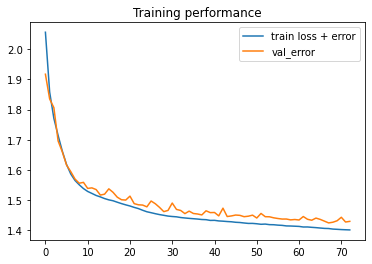

In [14]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

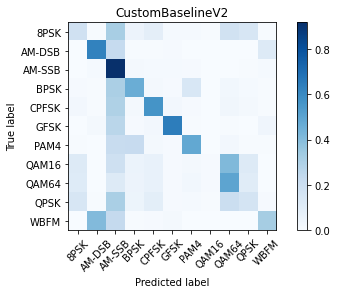

In [15]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08580980683506687


Overall Accuracy:  0.09390018484288355


Overall Accuracy:  0.10675150229763167


Overall Accuracy:  0.12543921293042867


Overall Accuracy:  0.16004335260115607


Overall Accuracy:  0.188327962764053


Overall Accuracy:  0.2859190254389108


Overall Accuracy:  0.37718023255813954


Overall Accuracy:  0.41178558750443733
Overall Accuracy:  0.5492451473759885


Overall Accuracy:  0.6379811183732752


Overall Accuracy:  0.6606563288856834


Overall Accuracy:  0.6595825426944971


Overall Accuracy:  0.6376865671641792
Overall Accuracy:  0.6397694524495677


Overall Accuracy:  0.6518410499453153
Overall Accuracy:  0.650129581636431


Overall Accuracy:  0.641594584430237


Overall Accuracy:  0.6595431098010317


Overall Accuracy:  0.6379928315412187


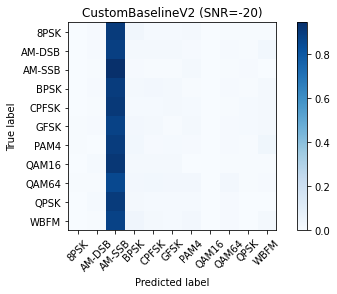

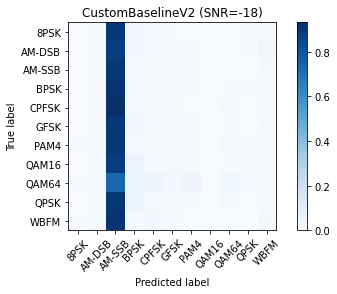

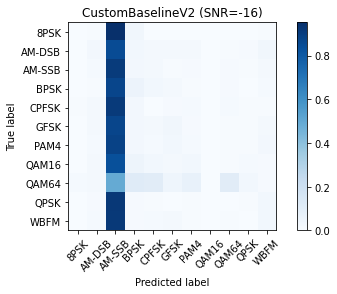

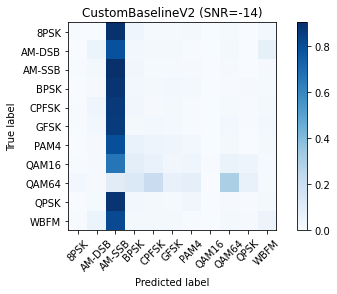

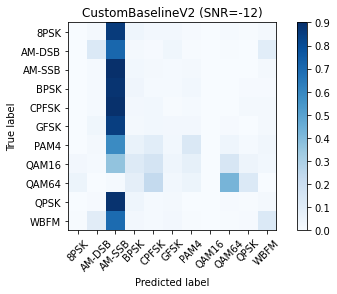

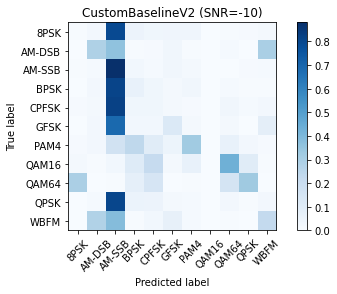

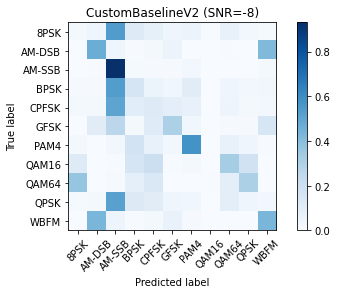

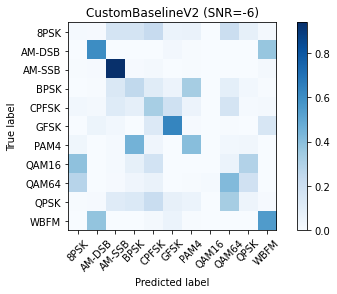

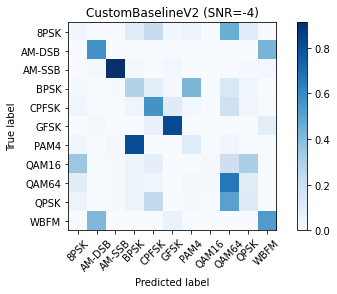

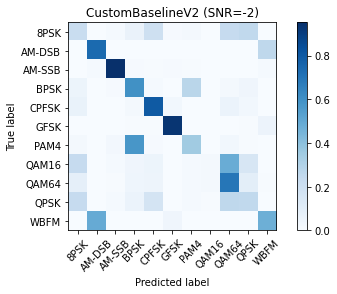

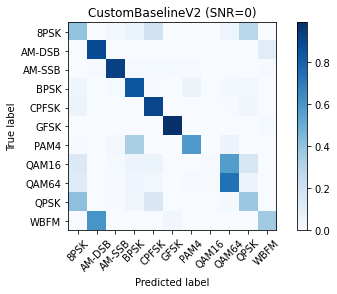

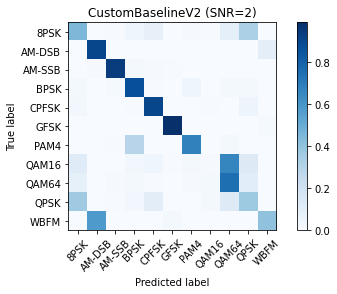

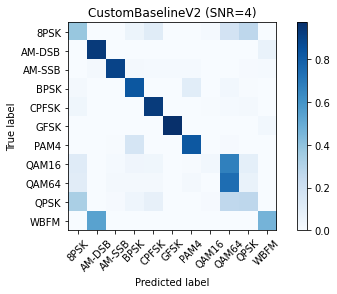

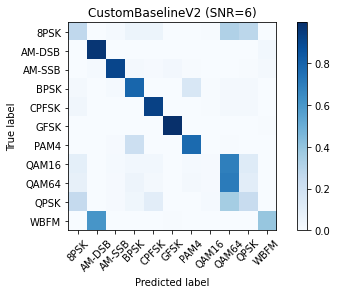

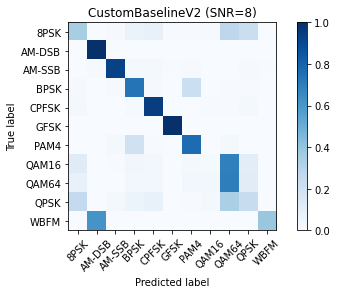

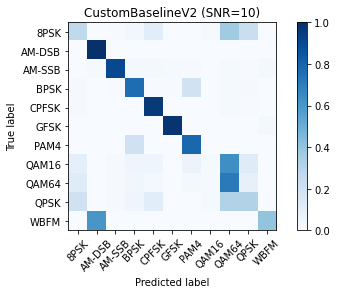

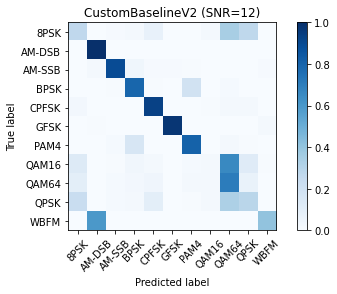

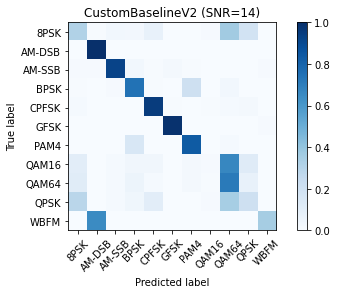

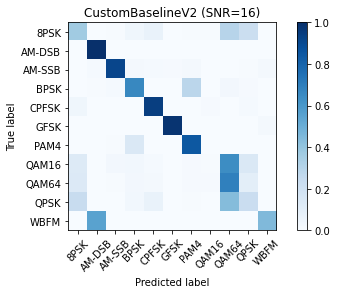

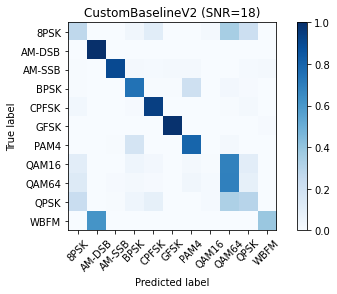

In [16]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [17]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,10,12,16,18,28,37,41,54,63,66,65,63,63,65,65,64,65,63


In [18]:
import statistics

statistics.mean(acc.values())

0.4430589591035066

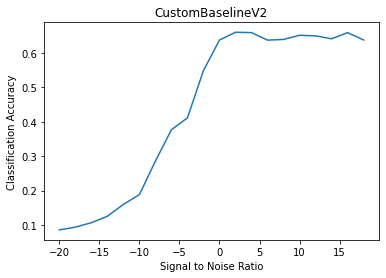

In [19]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)